# Loading the Data

In [191]:
import json
import re
from os.path import join
import os

import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import optuna
import shap
import cfbd
from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix, roc_auc_score
import numpy as np
from optuna.samplers import TPESampler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open('../config.json') as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)['CFBD_API_KEY']
    )

In [2]:
YEARS = range(2013, 2025)
DATA_DIR = '../data'

In [3]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower().replace('t_ds', 'tds'))
    return cols_new

In [4]:
# Load weather data
all_dfs = []

weather_dir = join(DATA_DIR, 'weather')
if not os.path.exists(weather_dir):
    os.makedirs(weather_dir)

for year in YEARS:
    file_path = join(weather_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} weather data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_weather(year=year)
        tmp = pd.DataFrame([val.to_dict() for val in data])
        tmp.columns = convert_to_snake_case(tmp.columns)
        tmp['season_type'] = tmp['season_type'].apply(lambda x: x.value)
        tmp.to_parquet(file_path)
    all_dfs.append(tmp)
del tmp

weather = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
weather.head()

Reading ../data/weather/2013.parquet from cached data
Reading ../data/weather/2014.parquet from cached data
Reading ../data/weather/2015.parquet from cached data
Reading ../data/weather/2016.parquet from cached data
Reading ../data/weather/2017.parquet from cached data
Reading ../data/weather/2018.parquet from cached data
Reading ../data/weather/2019.parquet from cached data
Reading ../data/weather/2020.parquet from cached data
Reading ../data/weather/2021.parquet from cached data
Reading ../data/weather/2022.parquet from cached data
Reading ../data/weather/2023.parquet from cached data
Reading ../data/weather/2024.parquet from cached data


,id,season,week,season_type,start_time,game_indoors,home_team,home_conference,away_team,away_conference,venue_id,venue,temperature,dew_point,humidity,precipitation,snowfall,wind_direction,wind_speed,pressure,weather_condition_code,weather_condition
0,333272229,2013,13,regular,2013-11-23 23:00:00+00:00,False,Florida International,Conference USA,Marshall,Conference USA,218,FIU Stadium,78.1,70.0,76.0,0.0,0,70.0,5.8,1015.9,NaN,None
1,333062229,2013,10,regular,2013-11-02 22:00:00+00:00,False,Florida International,Conference USA,East Carolina,Conference USA,218,FIU Stadium,84.9,65.8,53.0,0.0,0,260.0,7.0,1010.5,NaN,None
2,332992229,2013,9,regular,2013-10-26 22:00:00+00:00,False,Florida International,Conference USA,Louisiana Tech,Conference USA,218,FIU Stadium,79.0,61.0,54.0,0.0,0,60.0,11.4,1018.2,NaN,None
3,332852229,2013,7,regular,2013-10-12 23:30:00+00:00,False,Florida International,Conference USA,UAB,Conference USA,218,FIU Stadium,81.0,66.2,61.0,0.0,0,50.0,8.1,1015.9,NaN,None
4,332572229,2013,3,regular,2013-09-14 22:00:00+00:00,False,Florida International,Conference USA,Bethune-Cookman,MEAC,218,FIU Stadium,88.0,73.8,63.0,0.0,0,110.0,11.4,1013.0,NaN,None


In [5]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, 'games')
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in range(2012, 2025): # Adjusted to include 2012 for rolling window
    file_path = join(games_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} games data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        tmp = pd.DataFrame([val.to_dict() for val in data])
        tmp.columns = convert_to_snake_case(tmp.columns)
        tmp = tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        tmp['season_type'] = tmp['season_type'].apply(lambda x: x.value)
        tmp = tmp.assign(
            home_division=tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        tmp = tmp[id_cols + home_cols + away_cols]
        tmp.to_parquet(file_path)
    all_dfs.append(tmp)
del tmp

games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
games.head()

Reading ../data/games/2012.parquet from cached data
Reading ../data/games/2013.parquet from cached data
Reading ../data/games/2014.parquet from cached data
Reading ../data/games/2015.parquet from cached data
Reading ../data/games/2016.parquet from cached data
Reading ../data/games/2017.parquet from cached data
Reading ../data/games/2018.parquet from cached data
Reading ../data/games/2019.parquet from cached data
Reading ../data/games/2020.parquet from cached data
Reading ../data/games/2021.parquet from cached data
Reading ../data/games/2022.parquet from cached data
Reading ../data/games/2023.parquet from cached data
Reading ../data/games/2024.parquet from cached data


,id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo,start_date
0,322432710,2012,1,regular,True,False,3746.0,2710,Western Illinois,MVFC,fcs,23.0,NaN,2086,Butler,Pioneer,fcs,15.0,NaN,NaT
1,322432117,2012,1,regular,True,False,3786.0,2117,Central Michigan,Mid-American,fbs,38.0,NaN,2546,Southeast Missouri State,OVC,fcs,27.0,NaN,NaT
2,322432050,2012,1,regular,True,False,3919.0,2050,Ball State,Mid-American,fbs,37.0,1299.0,2199,Eastern Michigan,Mid-American,fbs,26.0,1231.0,NaT
3,322432006,2012,1,regular,True,False,3768.0,2006,Akron,Mid-American,fbs,14.0,997.0,2116,UCF,Conference USA,fbs,56.0,1559.0,NaT
4,322430238,2012,1,regular,True,False,3973.0,238,Vanderbilt,SEC,fbs,13.0,1573.0,2579,South Carolina,SEC,fbs,17.0,1743.0,NaT


In [6]:
# Load plays data
all_dfs = []
cols = ['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 'offense',
       'offense_conference', 'offense_score', 'defense', 'home', 'away',
       'defense_conference', 'defense_score', 'period', 'offense_timeouts',
       'defense_timeouts', 'yardline', 'yards_to_goal', 'down', 'distance',
       'yards_gained', 'scoring', 'play_type', 'play_text', 'ppa',
       'clock_minutes', 'clock_seconds']

plays_dir = join(DATA_DIR, 'plays')
if not os.path.exists(plays_dir):
    os.makedirs(plays_dir)

for year in range(2012, 2025):
    season_file_path = join(plays_dir, f'{year}.parquet')
    
    if os.path.exists(season_file_path):
        print(f'Reading {season_file_path} from cached data')
        season_plays = pd.read_parquet(season_file_path)
    else:
        print(f'Fetching all weeks plays data for {year} from CFBD API')
        weeks = games.query('season == @year').week.unique().tolist()

        season_dfs = []
        for week in weeks:
            print(f'Fetching {year} plays data for week {week} from CFBD API')
            with cfbd.ApiClient(configuration) as api_client:
                api_instance = cfbd.PlaysApi(api_client)
                data = api_instance.get_plays(year=year, week=week)
            tmp = pd.DataFrame([val.to_dict() for val in data])
            if tmp.empty:
                print(f'No plays data for {year} week {week}')
                continue
            tmp.columns = convert_to_snake_case(tmp.columns)

            tmp['clock_minutes'] = tmp['clock'].apply(lambda x: x['minutes'])
            tmp['clock_seconds'] = tmp['clock'].apply(lambda x: x['seconds'])
            tmp.drop(columns=['clock'], inplace=True)

            tmp = tmp[cols]
            season_dfs.append(tmp)
        
        season_plays = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)
        
        season_plays.to_parquet(season_file_path)
        print(f'Saved plays data for {year} to {season_file_path}')
        del season_dfs, tmp

    all_dfs.append(season_plays)

    del season_plays
    
plays = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
plays.columns = plays.columns.str.replace('t_ds', 'tds', regex=False)
plays.head()

Reading ../data/plays/2012.parquet from cached data
Reading ../data/plays/2013.parquet from cached data
Reading ../data/plays/2014.parquet from cached data
Reading ../data/plays/2015.parquet from cached data
Reading ../data/plays/2016.parquet from cached data
Reading ../data/plays/2017.parquet from cached data
Reading ../data/plays/2018.parquet from cached data
Reading ../data/plays/2019.parquet from cached data
Reading ../data/plays/2020.parquet from cached data
Reading ../data/plays/2021.parquet from cached data
Reading ../data/plays/2022.parquet from cached data
Reading ../data/plays/2023.parquet from cached data
Reading ../data/plays/2024.parquet from cached data


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_61249/2051513579.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plays = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)


,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds
0,322450221037,32245022104,322450221,4,1,Youngstown State,MVFC,7,Pittsburgh,Pittsburgh,Youngstown State,Big East,7,1,NaN,NaN,92,92,1,10,2,False,Rush,"Jamaine Cook rush for 2 yards to the YngSt 10,...",-0.207100,2,47
1,322450221048,32245022104,322450221,4,11,Youngstown State,MVFC,7,Pittsburgh,Pittsburgh,Youngstown State,Big East,7,2,NaN,NaN,36,36,2,4,0,False,Rush,"Kurt Hess rush for no gain to the Pitt 36, tac...",-0.903926,15,0
2,322450221044,32245022104,322450221,4,7,Youngstown State,MVFC,7,Pittsburgh,Pittsburgh,Youngstown State,Big East,7,2,NaN,NaN,59,59,1,10,0,False,Pass Incompletion,"Kurt Hess pass incomplete to Christian Bryan, ...",-1.138786,15,0
3,322450221045,32245022104,322450221,4,8,Youngstown State,MVFC,7,Pittsburgh,Pittsburgh,Youngstown State,Big East,7,2,NaN,NaN,59,59,2,10,5,False,Pass Completion,Kurt Hess pass complete to Marcel Caver for 5 ...,0.068045,15,0
4,322450221041,32245022104,322450221,4,5,Youngstown State,MVFC,7,Pittsburgh,Pittsburgh,Youngstown State,Big East,7,1,NaN,NaN,73,73,2,8,0,False,Pass Incompletion,"Kurt Hess pass incomplete to Christian Bryan, ...",-0.478808,2,47


In [7]:
elos = []
for year in YEARS:
    elos.append(pd.read_parquet(join(DATA_DIR, 'elo', f'{year}.parquet')))
elo = pd.concat(elos, ignore_index=True).reset_index(drop=True)
elo = elo.drop_duplicates(subset=['season', 'week', 'team_id'], keep='first')
elo.head()

,season,week,team_id,team,division,elo
0,2013,1,2,Auburn,fbs,2266.299104
2,2013,2,2,Auburn,fbs,2256.315253
3,2013,3,2,Auburn,fbs,2304.848707
4,2013,4,2,Auburn,fbs,2346.432593
5,2013,6,2,Auburn,fbs,2340.107671


In [8]:
# Load venue data
venue_dir = join(DATA_DIR, 'venues')
if not os.path.exists(venue_dir):
    os.makedirs(venue_dir)

file_path = join(venue_dir, f'venues.parquet')
if os.path.exists(file_path):
    print(f'Reading {file_path} from cached data')
    venues = pd.read_parquet(file_path)
else:
    print(f'Fetching {year} venue data from CFBD API')
    with cfbd.ApiClient(configuration) as api_client:
        api_instance = cfbd.VenuesApi(api_client)
        data = api_instance.get_venues()
    venues = pd.DataFrame([val.to_dict() for val in data])
    venues.columns = convert_to_snake_case(venues.columns)
    venues.to_parquet(file_path)

venues.head()

Reading ../data/venues/venues.parquet from cached data


,id,name,city,state,zip,country_code,latitude,longitude,capacity,dome,timezone,elevation,construction_year,grass
0,5938,Al Whitehead Field at Greyhound Stadium,Portales,NM,88130,US,34.186192,-103.334397,4000.0,False,None,None,NaN,None
1,218,FIU Stadium,Miami,FL,33199,US,25.752501,-80.377891,20000.0,False,America/New_York,1.718581796,1995.0,False
2,4779,Thomas A. Robinson National Stadium,Nassau,,None,BS,25.055569,-77.358736,15000.0,False,None,3.182889223,1981.0,True
3,5220,Garrison Stadium,Murfreesboro,TN,None,US,36.434053,-77.098431,5000.0,False,None,18.69116974,2007.0,None
4,6043,Bethpage Federal Credit Union Stadium,Brookville,NY,11545,US,40.816284,-73.589546,6000.0,False,America/New_York,236,1966.0,False


# Data Engineering

In [100]:
punt_plays = [
    'Punt', 
    'Punt Return Touchdown', 
    'Blocked Punt',
    'Blocked Punt Touchdown'
]

punt_attempts = (
    plays
    .merge(
        games[['id', 'season']].rename(columns={'id': 'game_id'}),
        on='game_id',
        how='left'
    )
    .query('season >= 2013')  # Filter out seasons before 2013
    .drop(columns=['season'])
    .assign(play_text=plays.play_text.fillna('')
            .str.replace(',', '', regex=False)
            .str.replace('.', '', regex=False)
            .str.lower())
    .assign(play_text=lambda x: ' ' + x.play_text + ' ')
    .query(
        'down.isin([1,2,3,4]) and '
        'period.isin([1, 2, 3, 4]) and '
        '(play_type.isin(@punt_plays) or '
        ' play_text.str.contains(" punt ")) and '
        ' ~play_text.str.contains(" fake ")' # # Exclude fake punts
    )
    .query('30 <= yards_to_goal <= 100')  # Filter for punts within the 30 to 100 yards range
    .assign(
        punt_outcome=lambda x: np.select(
            [   
                # Punt blocked safety
                x.play_text.str.contains(' blocked ') & x.play_text.str.contains(' safety '),
                # Punt blocked touchdown
                (x.play_text.str.contains(' blocked ') & x.play_text.str.contains(' touchdown ')) | 
                (x.play_type == "Blocked Punt Touchdown"),
                # Punt blocked
                x.play_text.str.contains(' blocked ') | (x.play_type == "Blocked Punt"),
                # Punt returned touchdown
                x.play_text.str.contains(' touchdown ') | (x.play_type == "Punt Return Touchdown"),
                # Punt touchback
                x.play_text.str.contains(' touchback '),
                # Punt returned
                (x.play_type == "Punt")
            ],
            [
                'blocked safety',
                'blocked touchdown',
                'blocked',
                'returned touchdown',
                'touchback',
                'returned'
            ],
            default='returned'
        )
    )
    .reset_index(drop=True)
)

punt_attempts.punt_outcome.value_counts()

punt_outcome
returned              107617
touchback               6921
blocked                  865
returned touchdown       205
blocked touchdown        134
blocked safety            56
Name: count, dtype: int64

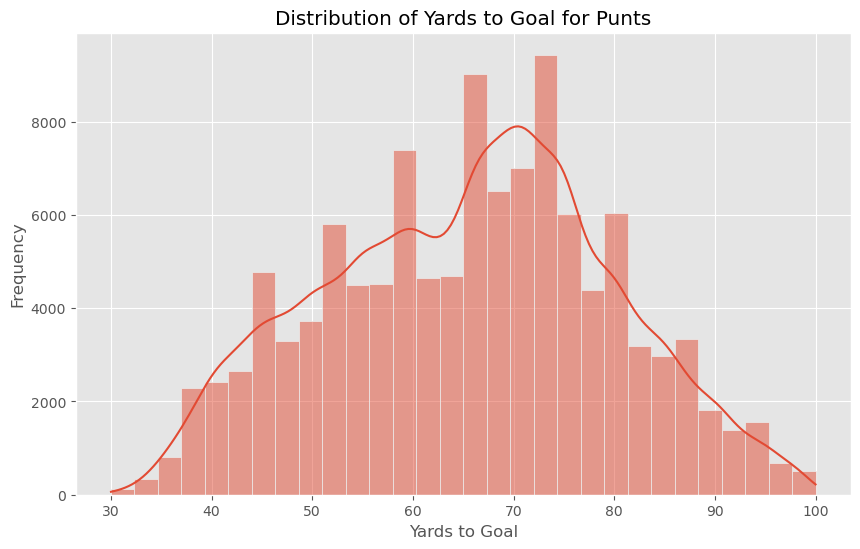

In [101]:
# plot the distirbutoin of yards_to_Goal when was_field_goal is True
plt.figure(figsize=(10, 6))
sns.histplot(punt_attempts['yards_to_goal'], bins=30, kde=True)
plt.title('Distribution of Yards to Goal for Punts')
plt.xlabel('Yards to Goal')
plt.ylabel('Frequency')
plt.show() 

In [102]:
id_cols = ['season', 'week', 'play_id', 'drive_id', 'game_id', 'drive_number', 
           'play_number', 'offense', 'defense', 'play_type','play_text']
features = [
    'offense_timeouts', 'defense_timeouts','yards_to_goal','score_diff',
    'seconds_remaining', 'pct_game_played', 'diff_time_ratio', 
    'is_home_team', 'grass', 'is_blowout',
    'elevation', 'offense_elo', 'defense_elo', 'elo_diff',
    'temperature', 'wind_speed', 'precipitation',
]
outcome_cols =['punt_outcome', 'punt_blocked']

punt_attempts = (
    punt_attempts
    .rename(columns={'id': 'play_id'})
    .assign(
        offense_timeouts = lambda x: np.where(x.offense_timeouts == -1, 0, x.offense_timeouts),
        defense_timeouts = lambda x: np.where(x.defense_timeouts == -1, 0, x.defense_timeouts),
    )
    .query('0 < yards_to_goal < 100 and 0 < distance < 100 and '
           '0 <= offense_timeouts <= 3 and 0 <= defense_timeouts <= 3 and '
           '0 <= clock_minutes <= 15 and 0 <= clock_seconds < 59')
    .assign(
        score_diff = lambda x: x['offense_score'] - x['defense_score'],
        seconds_remaining = lambda x: (
            (4 * 15 * 60) - # total game time in seconds
            ((x['period'] - 1) * 15 * 60) - # elapsed quarters in seconds
            (15 * 60 - (x['clock_minutes'] * 60 + x['clock_seconds'])) 
        )
    )
    .assign(
        pct_game_played = lambda x: (4 * 15 * 60 - x['seconds_remaining']) / (4 * 15 * 60),
        diff_time_ratio = lambda x: x['score_diff'] * np.exp(4 * (3600 - x['seconds_remaining']) / 3600),
        is_blowout=lambda x: (x['score_diff'] >= 21).astype(int),
    )
    .assign(
        punt_blocked=lambda x: np.where(
            x['punt_outcome'].isin(['blocked', 'blocked touchdown', 'blocked safety']),
            1, 0
        )
    )
    .merge(
        games[['id','season','week','venue_id','home_team','neutral_site']]
            .rename(columns={'id': 'game_id'}),
        on='game_id',
        how='left'
    )
    .merge(
        venues[['id','elevation','grass']].rename(columns={'id': 'venue_id'}),
        on='venue_id',
        how='left'
    )
    .merge(
        elo[['season', 'week', 'team', 'elo']]
            .rename(columns={
                'team': 'offense',
                'elo': 'offense_elo'
            }),
        left_on=['season', 'week', 'offense'],
        right_on=['season', 'week', 'offense'],
        how='left'
    )
    .merge(
        elo[['season', 'week', 'team', 'elo']]
            .rename(columns={
                'team': 'defense',
                'elo': 'defense_elo'
            }),
        left_on=['season', 'week', 'defense'],
        right_on=['season', 'week', 'defense'],
        how='left'
    )
    .assign(
        elo_diff=lambda x: x.offense_elo - x.defense_elo,
    )
    .merge(
        weather[['id','temperature','wind_speed','precipitation','game_indoors']]
            .rename(columns={'id': 'game_id'}),
        on='game_id',
        how='left'
    )
    .assign(
        wind_speed=lambda x: np.where(
            x.game_indoors, 0, x.wind_speed.fillna(int(x.wind_speed.mean()))
        ),
        precipitation=lambda x: np.where(
            x.game_indoors, 0, x.precipitation.fillna(int(x.precipitation.mean()))
        ),
        temperature=lambda x: np.where(
            x.game_indoors, 70, x.temperature.fillna(int(x.temperature.mean()))
        ),
        grass = lambda x: x.grass.fillna(False).astype(int),
        is_home_team=lambda x: np.where(
            x.neutral_site, 0, np.where(x.offense == x.home_team, 1, -1)
        ),
    )
    [id_cols + features + outcome_cols]
)
punt_attempts['elevation'] = (
    punt_attempts['elevation']
    .fillna(int(punt_attempts.elevation.astype(float).mean()))
    .astype(float)  
)
punt_attempts.head()

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_61249/1719947860.py:91: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  grass = lambda x: x.grass.fillna(False).astype(int),


,season,week,play_id,drive_id,game_id,drive_number,play_number,offense,defense,play_type,play_text,offense_timeouts,defense_timeouts,yards_to_goal,score_diff,seconds_remaining,pct_game_played,diff_time_ratio,is_home_team,grass,is_blowout,elevation,offense_elo,defense_elo,elo_diff,temperature,wind_speed,precipitation,punt_outcome,punt_blocked
0,2013,1,333610120226,33361012022,333610120,22,5,Maryland,Marshall,Punt,nathan renfro punt for 45 yards returned by d...,3.0,3.0,87,-4,353,0.901944,-147.535989,0,0,0,10.749901,1921.246102,1703.121251,218.124852,46.0,9.2,0.0,returned,0
1,2013,1,333610120093,33361012010,333610120,10,4,Maryland,Marshall,Punt,nathan renfro punt for 38 yards fair catch by...,3.0,3.0,68,-7,2269,0.369722,-30.716471,0,0,0,10.749901,1921.246102,1703.121251,218.124852,46.0,9.2,0.0,returned,0
2,2013,1,333610120027,33361012004,333610120,4,4,Maryland,Marshall,Punt,nathan renfro punt for 34 yards returned by d...,3.0,3.0,97,0,3189,0.114167,0.000000,0,0,0,10.749901,1921.246102,1703.121251,218.124852,46.0,9.2,0.0,returned,0
3,2013,1,333610120012,33361012002,333610120,2,4,Maryland,Marshall,Punt,nathan renfro punt for 47 yards returned by d...,3.0,3.0,86,0,3393,0.057500,0.000000,0,0,0,10.749901,1921.246102,1703.121251,218.124852,46.0,9.2,0.0,returned,0
4,2013,1,333610120160,33361012016,333610120,16,3,Maryland,Marshall,Punt,nathan renfro punt for 41 yards fair catch by...,3.0,3.0,85,-4,1399,0.611389,-46.147829,0,0,0,10.749901,1921.246102,1703.121251,218.124852,46.0,9.2,0.0,returned,0


# Model 1: Punt Blocked Model
Did not see an improvement over the baseline when using a model to predict if a punt is blocked. However, there is a relationship between punting team yards to goal and block rate. Modeled the probability with the linear relationship between punting team yards to goal and if the punt was blocked.

In [114]:
feature_names = [
    # 'offense_timeouts', 
    # 'defense_timeouts', 
    'yards_to_goal', 
    # 'score_diff',
    # 'seconds_remaining', 
    # 'pct_game_played', 
    # 'diff_time_ratio',
    # 'is_home_team', 
    # 'grass', 
    # 'is_blowout', 
    # 'elevation', 
    'offense_elo',
    'defense_elo', 
    # 'elo_diff',
    # 'temperature', 
    # 'wind_speed', 
    # 'precipitation',
]

target_variable = 'punt_blocked'

data = punt_attempts[feature_names + [target_variable]].copy()

SEED = 2

# Split the data into and 80-20 train-test split
train_data, test_data = train_test_split(
    data,  
    test_size=0.2, 
    random_state=SEED, 
    stratify=data[target_variable]
)
test_x, test_y = test_data[feature_names], test_data[target_variable]

# # Split into 80-20 train val set by game_id
train_x, valid_x, train_y, valid_y = train_test_split(
    train_data[feature_names], 
    train_data[target_variable], 
    test_size=0.2, 
    random_state=SEED, 
    stratify=train_data[target_variable]
)

In [115]:
train_y.value_counts(normalize=True)

punt_blocked
0    0.990886
1    0.009114
Name: proportion, dtype: float64

In [116]:
valid_y.value_counts(normalize=True)

punt_blocked
0    0.990914
1    0.009086
Name: proportion, dtype: float64

In [117]:
test_y.value_counts(normalize=True)

punt_blocked
0    0.990914
1    0.009086
Name: proportion, dtype: float64

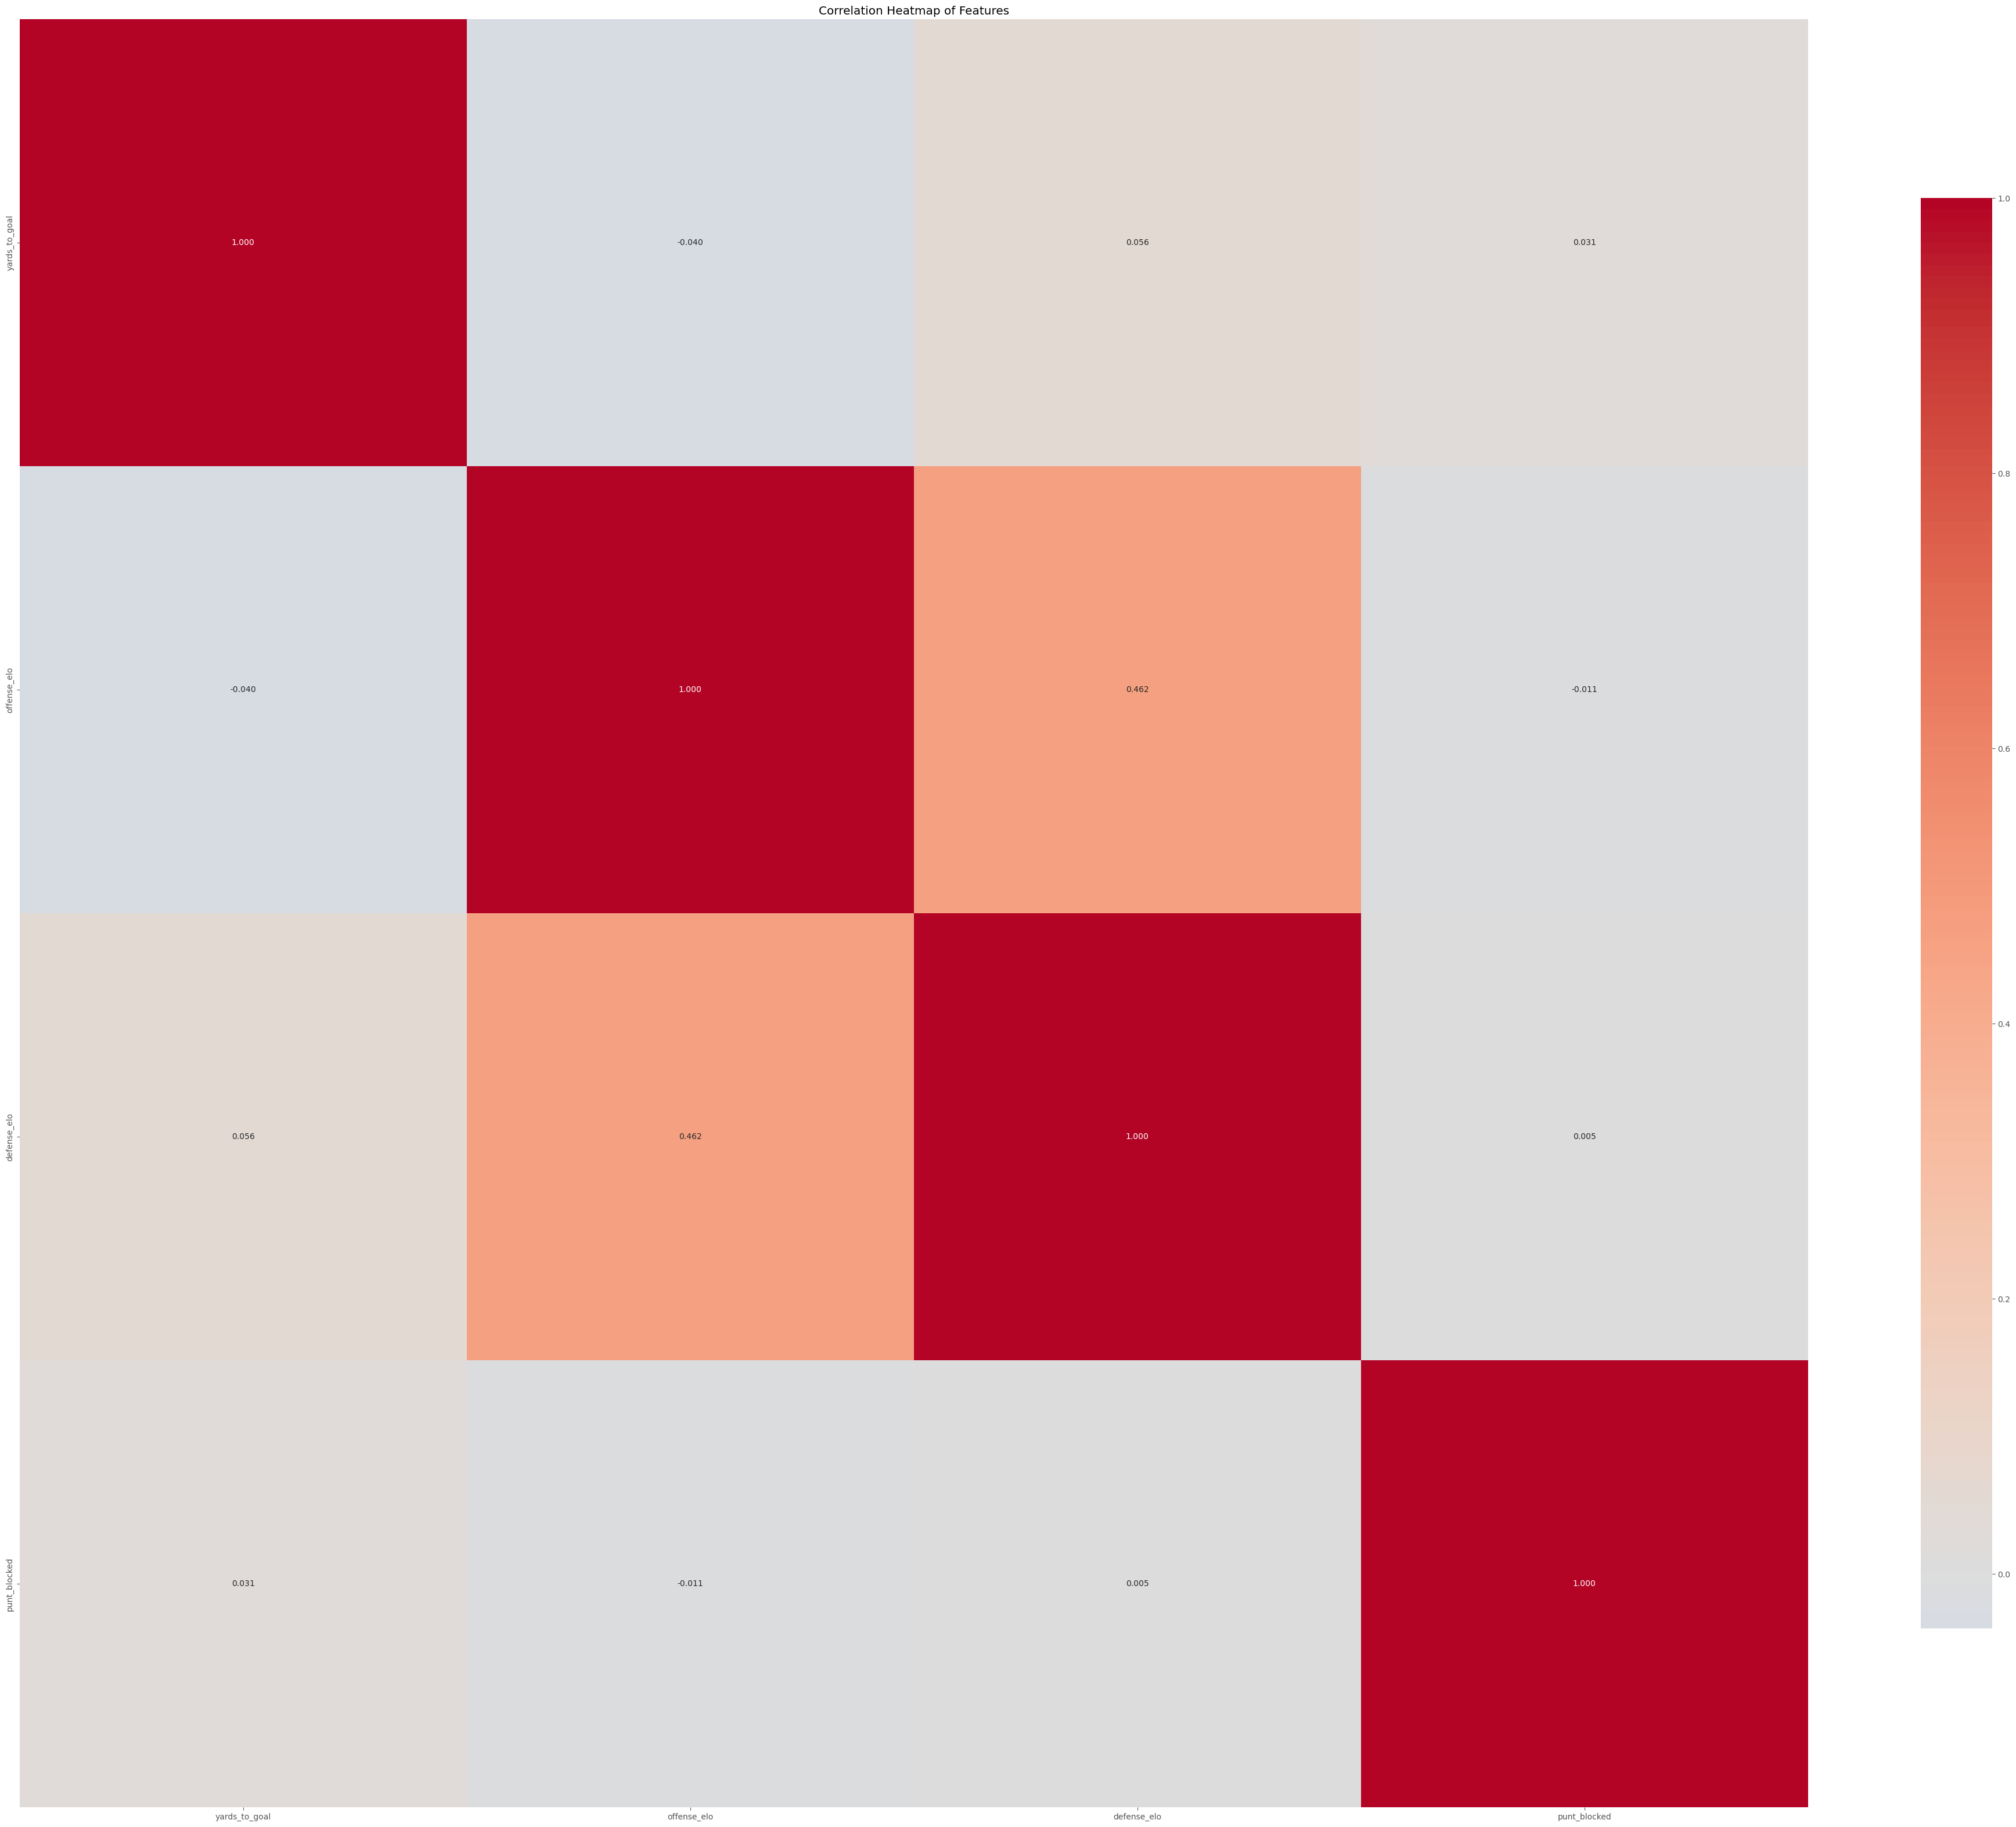

In [118]:
# correlation heatmap
plt.figure(figsize=(50, 40))
sns.heatmap(
    punt_attempts[feature_names + [target_variable]].corr(),
    annot=True, 
    fmt=".3f", 
    cmap='coolwarm', 
    center=0,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Correlation Heatmap of Features')
plt.show()

In [125]:
# from sklearn.utils.class_weight import compute_sample_weight
# train_sample_weights = compute_sample_weight(class_weight='balanced', y=train_y)
# valid_sample_weights = compute_sample_weight(class_weight='balanced', y=valid_y)

optuna.logging.set_verbosity(optuna.logging.CRITICAL)
SEED = 22
np.random.seed(SEED)

monotonic_constraints_map = {
    "yards_to_goal": -1,
    "offense_elo": -1,
    "defense_elo": 1,
}
monotonic_constraints = tuple([monotonic_constraints_map.get(feature, 0) for feature in feature_names])

# Objective function for Optuna
def objective(trial, dtrain, dvalid):
    param = {
        "nthread": -1,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "booster": "gbtree",
        "monotone_constraints": monotonic_constraints,
        "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
        "eta": trial.suggest_float("eta", 0.05, 0.3, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        "min_child_weight": trial.suggest_float("min_child_weight", .5, 10, step=.5),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "seed": SEED,
    }
    
    bst = xgb.train(
        param, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False,
    )
    preds = bst.predict(dvalid)
    
    # Calculate multiclass log loss
    return log_loss(valid_y, preds)

# Create DMatrix objects
dtrain = xgb.DMatrix(train_x, label=train_y) #, weight=train_sample_weights)
dvalid = xgb.DMatrix(valid_x, label=valid_y) #, weight=valid_sample_weights)

# Run Optuna optimization
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(
    study_name="blocked_fg_optimization",
    direction="minimize", 
    load_if_exists=True,
    sampler=sampler
)
study.optimize(
    lambda trial: objective(trial, dtrain, dvalid), 
    n_trials=30,
    show_progress_bar=True
)

# Train final model with best parameters
best_params = {
    **study.best_trial.params,
    'monotone_constraints': monotonic_constraints,
    'nthread': -1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'booster': 'gbtree',
    'seed': SEED,
}

final_model = xgb.train(
    best_params, 
    dtrain,
    num_boost_round=500,
    evals=[(dvalid, "eval")],
    early_stopping_rounds=10,
    verbose_eval=False
)
print(f"Number of boosted rounds: {final_model.best_iteration}")

  0%|          | 0/30 [00:00<?, ?it/s]

Number of boosted rounds: 7


In [126]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score, log_loss

# Helper to compute all metrics
def evaluate_set(name, X, y_true):
    dmatrix = xgb.DMatrix(X)
    y_proba = final_model.predict(dmatrix)
    y_pred = np.where(y_proba > 0.5, 1, 0)

    bal_acc = balanced_accuracy_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    ce_loss = log_loss(y_true, y_proba)

    print(f"\n=== {name.upper()} SET METRICS ===")
    print(f"Balanced Accuracy : {bal_acc:.4f}")
    print(f"Accuracy          : {acc:.4f}")
    print(f"Macro F1 Score    : {macro_f1:.4f}")
    print(f"Log Loss          : {ce_loss:.4f}")

# Evaluate each split
evaluate_set("Train", train_x, train_y)
evaluate_set("Validation", valid_x, valid_y)
evaluate_set("Test", test_x, test_y)


=== TRAIN SET METRICS ===
Balanced Accuracy : 0.5000
Accuracy          : 0.9909
Macro F1 Score    : 0.4977
Log Loss          : 0.0518

=== VALIDATION SET METRICS ===
Balanced Accuracy : 0.5000
Accuracy          : 0.9909
Macro F1 Score    : 0.4977
Log Loss          : 0.0517

=== TEST SET METRICS ===
Balanced Accuracy : 0.5000
Accuracy          : 0.9909
Macro F1 Score    : 0.4977
Log Loss          : 0.0517


In [131]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt

# class_names = ['Not Blocked', 'Blocked']

# # Get predicted labels on test set
# dtest = xgb.DMatrix(test_x)
# y_test_proba = final_model.predict(dtest)
# y_test_pred = np.where(y_test_proba > 0.5, 1, 0)

# # Compute confusion matrix
# cm = confusion_matrix(test_y, y_test_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# # Plot non-normalized
# disp.plot(cmap='Blues', values_format='d')
# plt.title("Confusion Matrix (Raw Counts)")
# plt.grid(False)
# plt.show()

# # Plot normalized by true labels (per-class recall)
# cm_normalized = confusion_matrix(test_y, y_test_pred, normalize='true')
# disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
# disp_norm.plot(cmap='Blues', values_format=".2f")
# plt.title("Confusion Matrix (Normalized by True Class)")
# plt.grid(False)
# plt.show()

In [132]:
from sklearn.dummy import DummyClassifier

# Fit a dummy classifier that always predicts class probabilities
dummy = DummyClassifier(strategy="prior")
dummy.fit(train_x, train_y)  # train_y should be encoded (0, 1, 2, 3)

# Evaluate on test set
dummy_probs = dummy.predict_proba(test_x)
dummy_bal_acc = balanced_accuracy_score(test_y, dummy.predict(test_x))
dummy_acc = accuracy_score(test_y, dummy.predict(test_x))
dummy_macro_f1 = f1_score(test_y, dummy.predict(test_x), average='macro')
dummy_ce_loss = log_loss(test_y, dummy_probs) 

print("\n=== DUMMY CLASSIFIER METRICS ===")
print(f"Balanced Accuracy : {dummy_bal_acc:.4f}")
print(f"Accuracy          : {dummy_acc:.4f}")
print(f"Macro F1 Score    : {dummy_macro_f1:.4f}")
print(f"Log Loss          : {dummy_ce_loss:.4f}")


=== DUMMY CLASSIFIER METRICS ===
Balanced Accuracy : 0.5000
Accuracy          : 0.9909
Macro F1 Score    : 0.4977
Log Loss          : 0.0518


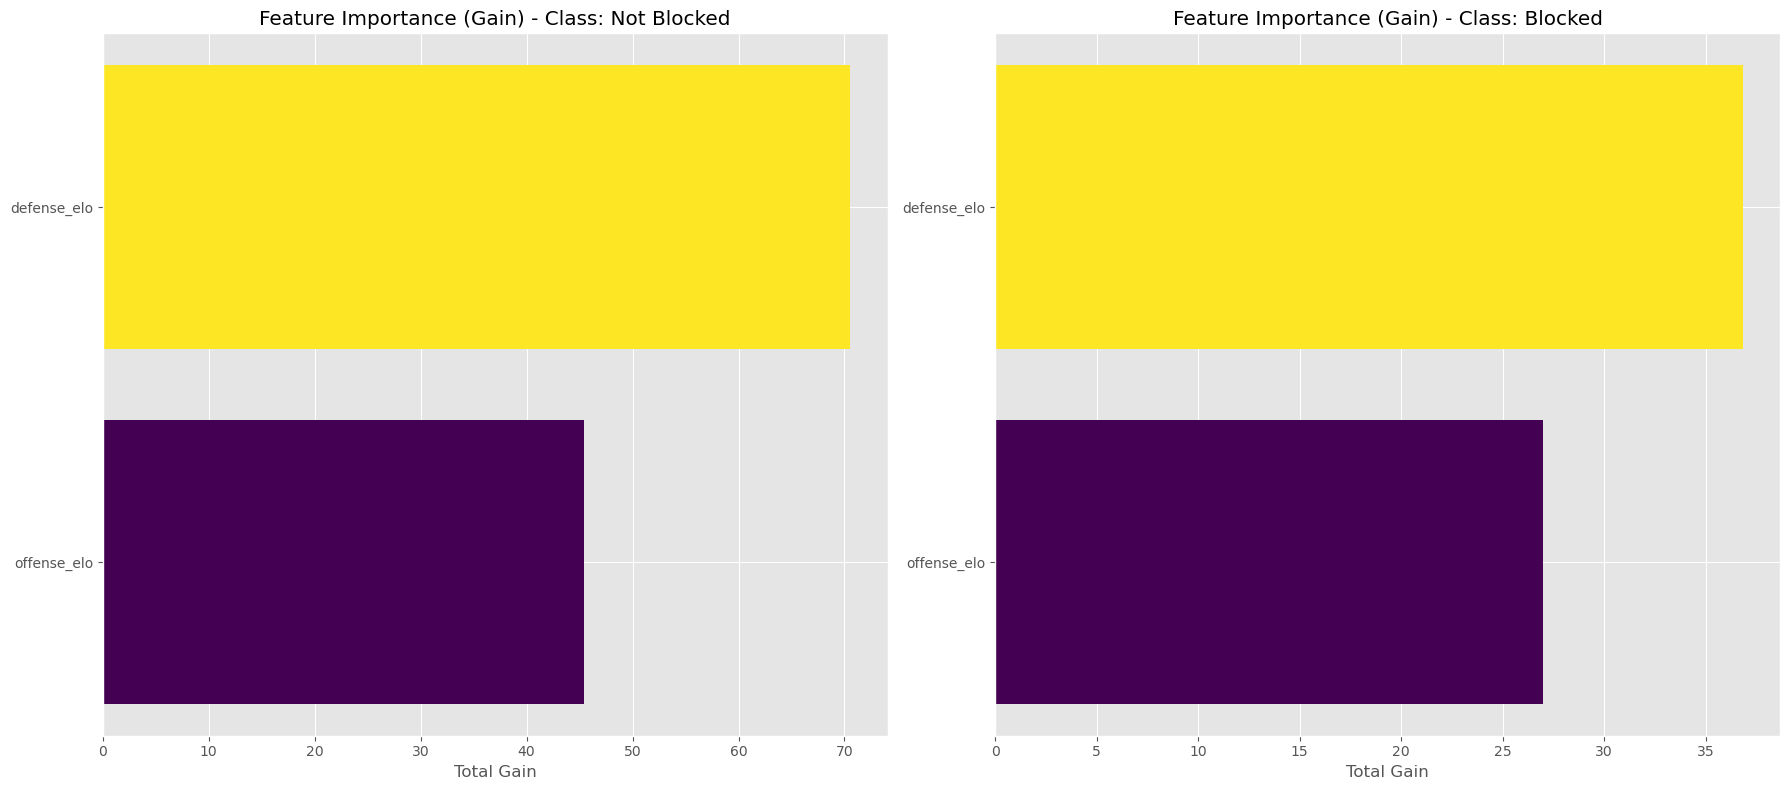

In [129]:
import matplotlib.cm as cm

num_classes = 2
class_names = ['Not Blocked', 'Blocked']
trees_df = final_model.trees_to_dataframe()

fig, axes = plt.subplots(1,2, figsize=(18, 8))
axes = axes.flatten()

for class_id in range(num_classes):
    class_trees = trees_df[trees_df['Tree'] % num_classes == class_id]
    class_gain = (
        class_trees[class_trees['Feature'] != 'Leaf']
        .groupby('Feature')['Gain']
        .sum()
        .sort_values(ascending=False)
    )
    top_features = class_gain[:20]
    norm = plt.Normalize(top_features.min(), top_features.max())
    colors = cm.viridis(norm(top_features.values))

    ax = axes[class_id]
    ax.barh(top_features.index, top_features.values, color=colors)
    ax.set_title(f"Feature Importance (Gain) - Class: {class_names[class_id]}")
    ax.invert_yaxis()
    ax.set_xlabel("Total Gain")

plt.tight_layout()
plt.show()


100%|██████████| 10/10 [00:00<00:00, 228.24it/s]
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_61249/506683757.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values,


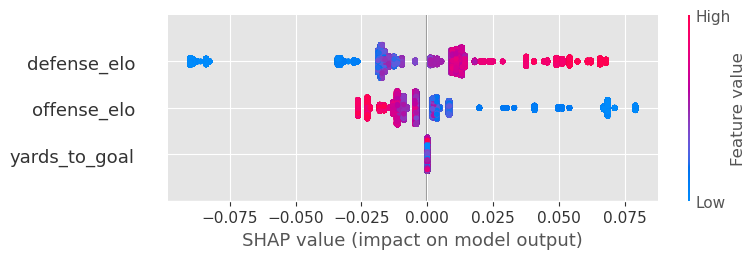

In [130]:
chunk_size = 10000
n_row = 100000

background = train_data[feature_names].iloc[:n_row]
explainer = shap.TreeExplainer(final_model)

num_rows = background.shape[0]

shap_values = []

for i in tqdm(range(0, num_rows, chunk_size)):
    chunk = background.iloc[i:i+chunk_size]
    shap_chunk = explainer(chunk)
    shap_values.append(shap_chunk.values)

shap_values = np.concatenate(shap_values, axis=0)

shap.summary_plot(shap_values, 
                 background,
                 plot_type="dot",  # "dot" (default), "bar", or "violin"
                 max_display=15,
                 show=True)

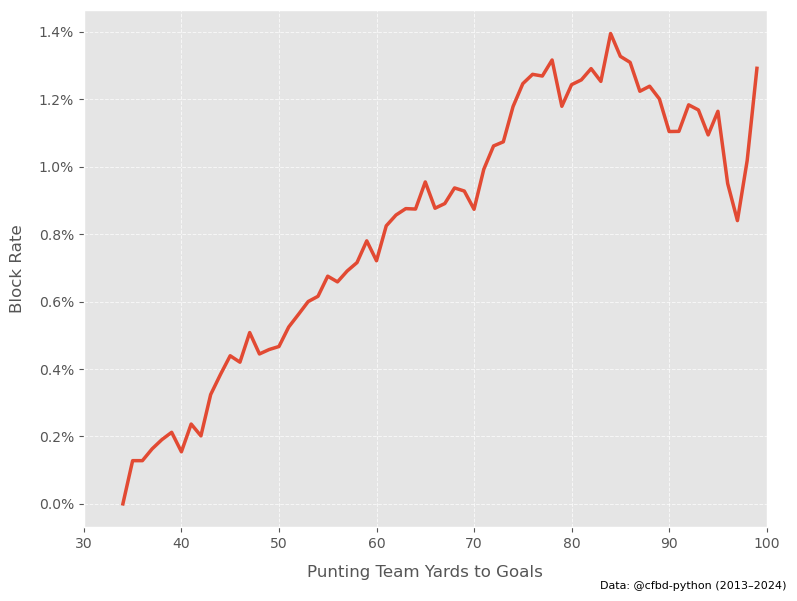

In [75]:
rolling = (
    punt_attempts
    .sort_values('yards_to_goal')
    .groupby('yards_to_goal')
    .agg(blocked_rate=('punt_blocked', 'mean'),
         count=('punt_blocked', 'count'))
    .rolling(window=5, min_periods=5)
    .mean()
    .reset_index()
)

plt.style.use('ggplot')

plt.figure(figsize=(8, 6))

ax = sns.lineplot(x='yards_to_goal', y='blocked_rate', data=rolling, 
                 linewidth=2.5, color='#E24A33')

# Title + subtitle separation
# ax.set_title('Longer Field Goal Attempts Are Blocked More Often', 
#              fontsize=16, pad=12, loc='left', y=1.07)

ax.set_xlabel('Punting Team Yards to Goals', fontsize=12, labelpad=10)
ax.set_ylabel('Block Rate', fontsize=12, labelpad=10)

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1%}'))
ax.set_xticks(range(30, 101, 10))
ax.grid(True, which='major', linestyle='--', linewidth=0.7, alpha=0.7)

ax.set_xlim(30, 100)
plt.figtext(
    0.99, 0.01,
    'Data: @cfbd-python (2013–2024)', 
    horizontalalignment='right', 
    fontsize=8, 
)

plt.tight_layout()
plt.show()

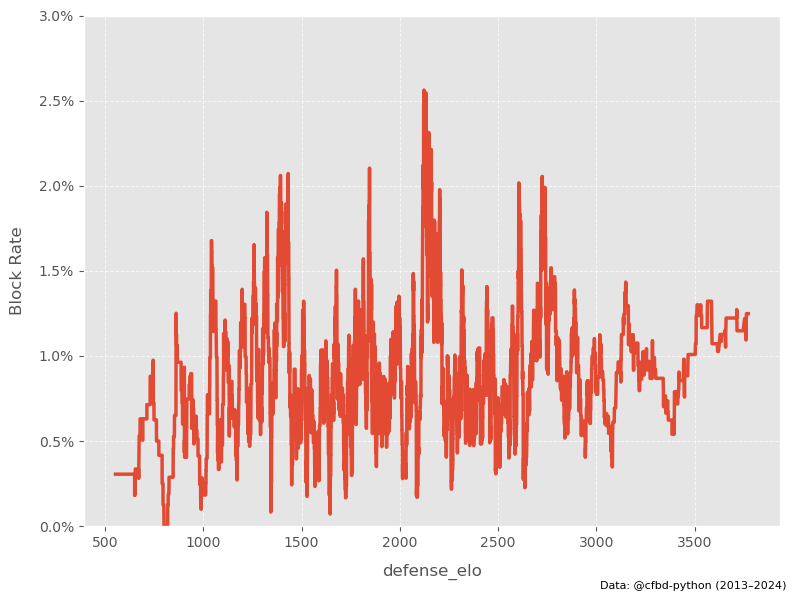

In [144]:
feature = 'defense_elo' 
rolling = (
    punt_attempts
    .sort_values(feature)
    .groupby(feature)
    .agg(blocked_rate=('punt_blocked', 'mean'),
         count=('punt_blocked', 'count'))
    .rolling(window=200, min_periods=200)
    .mean()
    .reset_index()
)

plt.style.use('ggplot')

plt.figure(figsize=(8, 6))

ax = sns.lineplot(x=feature, y='blocked_rate', data=rolling, 
                 linewidth=2.5, color='#E24A33')

# Title + subtitle separation
# ax.set_title('Longer Field Goal Attempts Are Blocked More Often', 
#              fontsize=16, pad=12, loc='left', y=1.07)

ax.set_xlabel(feature, fontsize=12, labelpad=10)
ax.set_ylabel('Block Rate', fontsize=12, labelpad=10)

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1%}'))
# ax.set_xticks(range(30, 101, 10))
ax.grid(True, which='major', linestyle='--', linewidth=0.7, alpha=0.7)

# ax.set_xlim(30, 100)
ax.set_ylim(0, 0.03)
plt.figtext(
    0.99, 0.01,
    'Data: @cfbd-python (2013–2024)', 
    horizontalalignment='right', 
    fontsize=8, 
)

plt.tight_layout()
plt.show()

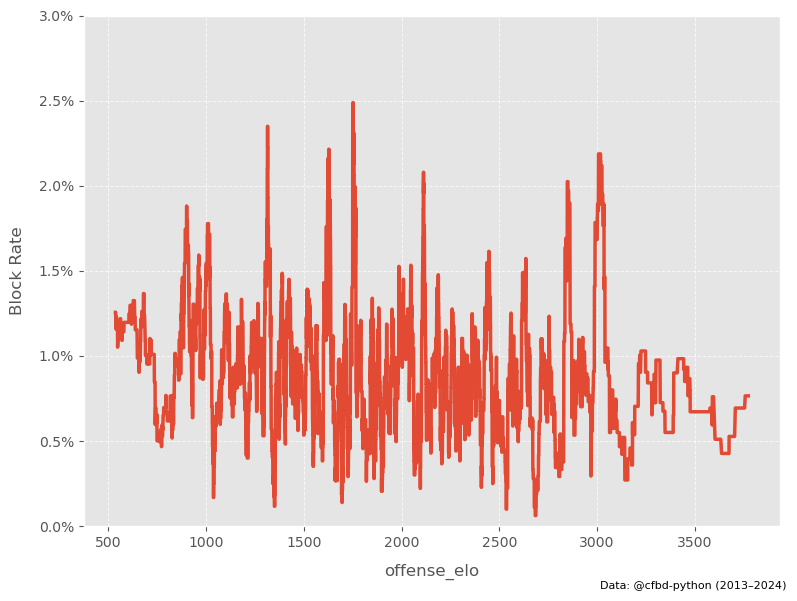

In [145]:

feature = 'offense_elo' 
rolling = (
    punt_attempts
    .sort_values(feature)
    .groupby(feature)
    .agg(blocked_rate=('punt_blocked', 'mean'),
         count=('punt_blocked', 'count'))
    .rolling(window=200, min_periods=200)
    .mean()
    .reset_index()
)

plt.style.use('ggplot')

plt.figure(figsize=(8, 6))

ax = sns.lineplot(x=feature, y='blocked_rate', data=rolling, 
                 linewidth=2.5, color='#E24A33')

# Title + subtitle separation
# ax.set_title('Longer Field Goal Attempts Are Blocked More Often', 
#              fontsize=16, pad=12, loc='left', y=1.07)

ax.set_xlabel(feature, fontsize=12, labelpad=10)
ax.set_ylabel('Block Rate', fontsize=12, labelpad=10)

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1%}'))
# ax.set_xticks(range(30, 101, 10))
ax.grid(True, which='major', linestyle='--', linewidth=0.7, alpha=0.7)

# ax.set_xlim(30, 100)
ax.set_ylim(0, 0.03)
plt.figtext(
    0.99, 0.01,
    'Data: @cfbd-python (2013–2024)', 
    horizontalalignment='right', 
    fontsize=8, 
)

plt.tight_layout()
plt.show()

In [77]:
punt_attempts['yards_to_goal_bin'] = (punt_attempts['yards_to_goal'] // 5) * 5

# Calculate mean blocked rate
blocked_rate = (
    punt_attempts
    .groupby('yards_to_goal_bin')['punt_blocked']
    .mean()
    .reset_index()
    .rename(columns={'yards_to_goal_bin': 'yards_to_goal', 'punt_blocked': 'blocked_rate'})
)

# Calculate count per bin
bin_counts = (
    punt_attempts
    .groupby('yards_to_goal_bin')
    .size()
    .reset_index(name='count')
    .rename(columns={'yards_to_goal_bin': 'yards_to_goal'})
)

# Merge the two
yards_to_goal_blocked_rate = (
    pd.merge(blocked_rate, bin_counts, on='yards_to_goal')
    .rename(columns={'yards_to_goal': 'yards_to_goal_bin_center'})
    .assign(
        yards_to_goal_bin_center=lambda x: x.yards_to_goal_bin_center + 2.5,  # Center the bin
    )
)
yards_to_goal_blocked_rate

,yards_to_goal_bin_center,blocked_rate,count
0,32.5,0.000000,465
1,37.5,0.001659,3013
2,42.5,0.003900,6411
3,47.5,0.004580,8078
4,52.5,0.006152,9590
5,57.5,0.007864,11444
6,62.5,0.008708,11598
7,67.5,0.009191,15124
8,72.5,0.011713,16051
9,77.5,0.011881,12120


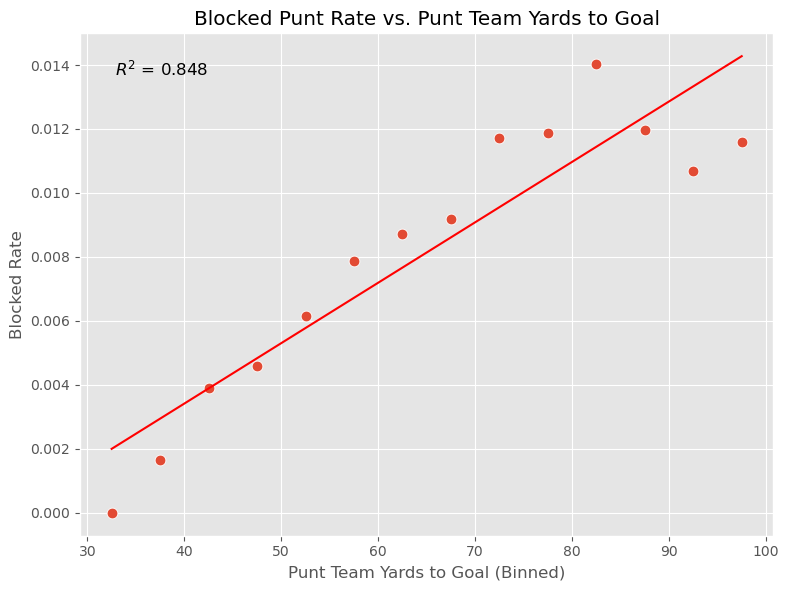

Intercept (b): -0.00414
Slope (m): 0.00019


In [80]:
from scipy.stats import linregress

# Fit a line: blocked_rate = m * fg_distance + b
slope, intercept, r_value, p_value, std_err = linregress(
    yards_to_goal_blocked_rate['yards_to_goal_bin_center'], 
    yards_to_goal_blocked_rate['blocked_rate']
)

# Add fitted line to the DataFrame
yards_to_goal_blocked_rate['predicted_blocked_rate'] = (
    slope * yards_to_goal_blocked_rate['yards_to_goal_bin_center'] + intercept
)

# Optional: visualize
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(data=yards_to_goal_blocked_rate, x='yards_to_goal_bin_center', y='blocked_rate', s=60)
sns.lineplot(data=yards_to_goal_blocked_rate, x='yards_to_goal_bin_center', y='predicted_blocked_rate', color='red')
# R-squared value
r_squared = r_value ** 2
plt.text(0.05, 0.95, f'$R^2$ = {r_squared:.3f}', 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.title('Blocked Punt Rate vs. Punt Team Yards to Goal')
plt.xlabel('Punt Team Yards to Goal (Binned)')
plt.ylabel('Blocked Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

# For your model:
print(f"Intercept (b): {intercept:.5f}")
print(f"Slope (m): {slope:.5f}")

# Model 2: Punt Return Yardline Model

In [171]:
len(punt_attempts.query('punt_blocked == 0'))

111779

In [172]:
punt_attempts.query('punt_blocked == 0').punt_outcome.value_counts()

punt_outcome
returned              104871
touchback               6707
returned touchdown       201
Name: count, dtype: int64

In [176]:
# First assign time-based features
plays_with_next = (
    plays.rename(columns={
        'id': 'play_id',
    })
    .assign(
        pct_game_played = (
            (((plays['period'] - 1) * 15 * 60)
            + ((15 * 60) - (plays['clock_minutes'] * 60 + plays['clock_seconds']))) 
            / (4 * 15 * 60)
        ),
        seconds_remaining = (
            (4 * 15 * 60)
            - ((plays['period'] - 1) * 15 * 60)
            - (15 * 60 - (plays['clock_minutes'] * 60 + plays['clock_seconds']))
        )
    )
    .dropna(subset=['game_id','offense', 'yards_to_goal'])
    .sort_values(['game_id','pct_game_played'], ascending=[True, True])
)

# Then apply shifts within each game using a lambda
plays_with_next = (
    plays_with_next
    .assign(
        next_play_number = plays_with_next['play_number'].shift(-1),
        next_drive_number = plays_with_next['drive_number'].shift(-1),
        next_offense = plays_with_next['offense'].shift(-1),
        next_game_id = plays_with_next['game_id'].shift(-1),
        next_yards_to_goal = plays_with_next['yards_to_goal'].shift(-1),
        next_pct_game_played = plays_with_next['pct_game_played'].shift(-1),
        next_seconds_remaining = plays_with_next['seconds_remaining'].shift(-1),
    )
)


punt_return_results = pd.merge(
    punt_attempts.query('punt_blocked == 0'),
    plays_with_next[['game_id', 'play_id', 'next_play_number', 'next_drive_number', 
                    'next_offense', 'next_game_id', 'next_yards_to_goal', 
                    'next_pct_game_played', 'next_seconds_remaining']],
    on=['game_id', 'play_id'],
    how='left'
)

punt_return_results = punt_return_results[
    (
        (punt_return_results['next_offense'] != punt_return_results['offense']) &  # Possession changes
        (punt_return_results['next_game_id'] == punt_return_results['game_id']) &  # Same game
        (punt_return_results['next_pct_game_played'] >= punt_return_results['pct_game_played']) &  # Time moves forward
        (punt_return_results['next_pct_game_played'] <= (punt_return_results['pct_game_played'] + 0.01))  # Within reasonable time window
    ) |
    (
        punt_return_results['punt_outcome'].isin(['returned touchdown', 'touchback']) # Special cases for touchdowns and touchbacks
    )
]

punt_return_results['new_team_yards_to_goal'] = np.where(
    punt_return_results['punt_outcome'] == 'returned touchdown',
    0,  # Touchdown results in 0 yards to goal
    np.where(
        punt_return_results['punt_outcome'] == 'touchback',
        80,  # Touchback results in 20 yards to goal off of a punt
        punt_return_results['next_yards_to_goal']  # For all other cases, use next yards to goal
    )
)

punt_return_results = (
    punt_return_results
    .assign(
        receiving_team_yards_to_goal = np.where(
            punt_return_results.new_team_yards_to_goal < 0,
            0,
            np.where(
                punt_return_results.new_team_yards_to_goal > 100,
                99,
                punt_return_results.new_team_yards_to_goal
            )
        ),
    )
)
punt_return_results = (
    punt_return_results
    .assign(
        yards_gained =(100 - punt_return_results['yards_to_goal']) - punt_return_results['receiving_team_yards_to_goal'],
        seconds_used = punt_return_results['seconds_remaining'] - punt_return_results['next_seconds_remaining'],
        endzone_punt = np.where(
            punt_return_results['punt_outcome'].isin(['returned touchdown', 'touchback']),
            1,
            0
        ),
    )
)

print(f"Found {len(punt_return_results)} blocked punts with valid next play data")

Found 61986 blocked punts with valid next play data


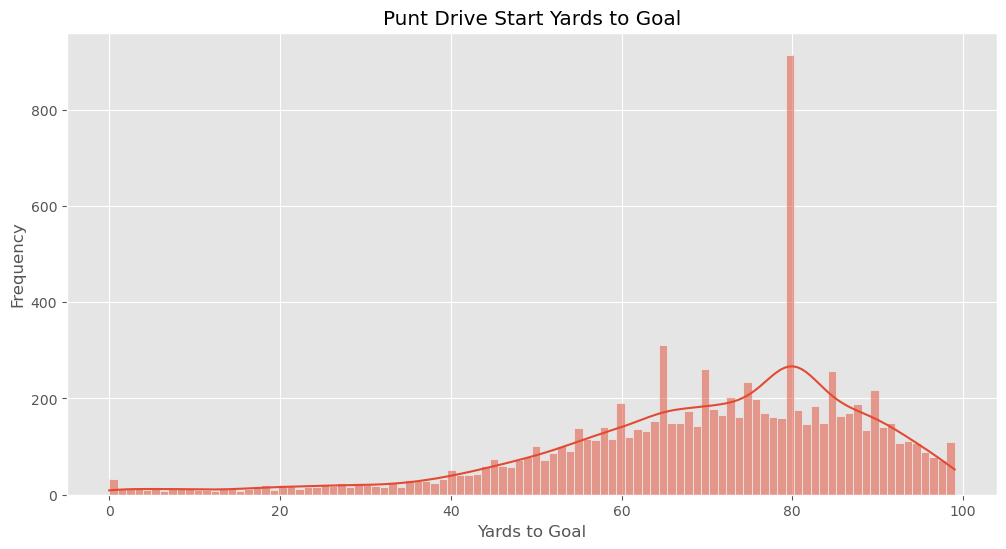

In [186]:
# plot a histogram of punt drive start yards to goal
plt.figure(figsize=(12,6))
sns.histplot(punt_return_results.query('season == 2024').receiving_team_yards_to_goal, bins=100, kde=True)
plt.title("Punt Drive Start Yards to Goal")
plt.xlabel("Yards to Goal")
plt.ylabel("Frequency")
plt.show()

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_61249/3157735172.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(pd.cut(punt_return_results.yards_to_goal, np.linspace(0, 100, 101)))


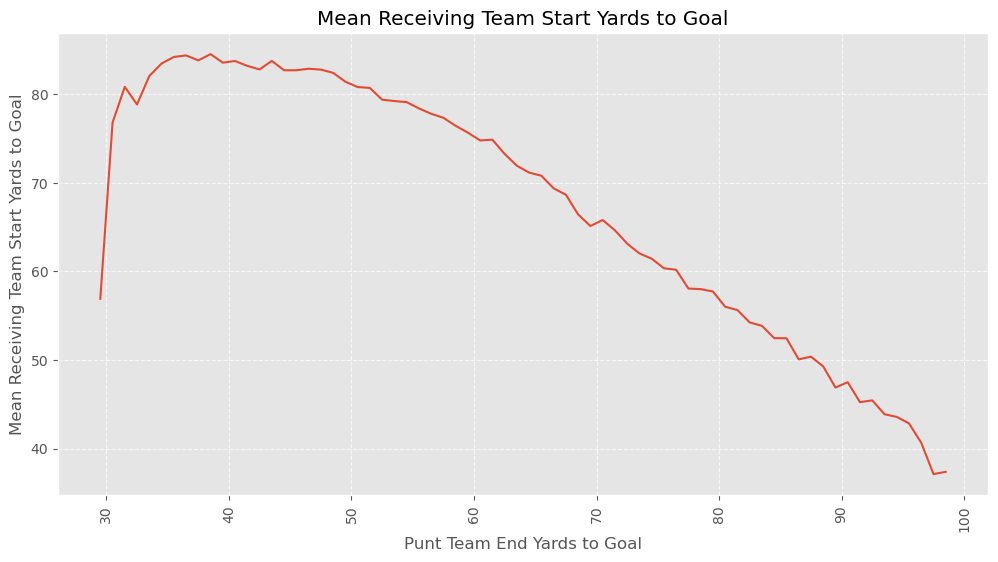

In [188]:
# Create the DataFrame with binned data
df_punt_start_yards_to_goal = (
    punt_return_results
    .groupby(pd.cut(punt_return_results.yards_to_goal, np.linspace(0, 100, 101)))
    .agg(receiving_team_yards_to_goal_mean=('receiving_team_yards_to_goal', 'mean'))
    .reset_index()
)

# Convert the categorical bins to numeric midpoints
df_punt_start_yards_to_goal['yards_to_goal'] = df_punt_start_yards_to_goal['yards_to_goal'].apply(
    lambda x: x.mid if pd.notnull(x) else np.nan  # Use the midpoint of the bin
)

# Plot the mean receiving team start yards to goal
plt.figure(figsize=(12, 6))
sns.lineplot(
    x='yards_to_goal', 
    y='receiving_team_yards_to_goal_mean', 
    data=df_punt_start_yards_to_goal
)
plt.title("Mean Receiving Team Start Yards to Goal")
plt.xlabel("Punt Team End Yards to Goal")
plt.ylabel("Mean Receiving Team Start Yards to Goal")
plt.xticks(rotation=90)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [221]:
feature_names = [
    # 'offense_timeouts',
    # 'defense_timeouts',
    'yards_to_goal',
    # 'score_diff',
    # 'pct_game_played',
    # 'diff_time_ratio',
    # 'is_home_team',
    # 'grass',
    # 'is_blowout',
    'elevation',
    'offense_elo',
    'defense_elo',
    # 'elo_diff',
    'temperature',
    'wind_speed',
    # 'precipitation',
]

target_variable = 'receiving_team_yards_to_goal'

data = punt_return_results[feature_names + [target_variable]].copy()

SEED = 2

# Split the data into and 80-20 train-test split
train_data, test_data = train_test_split(
    data,  
    test_size=0.2, 
    random_state=SEED, 
    stratify=data[target_variable]
)
test_x, test_y = test_data[feature_names], test_data[target_variable]

# # Split into 80-20 train val set by game_id
train_x, valid_x, train_y, valid_y = train_test_split(
    train_data[feature_names], 
    train_data[target_variable], 
    test_size=0.2, 
    random_state=SEED, 
    stratify=train_data[target_variable]
)

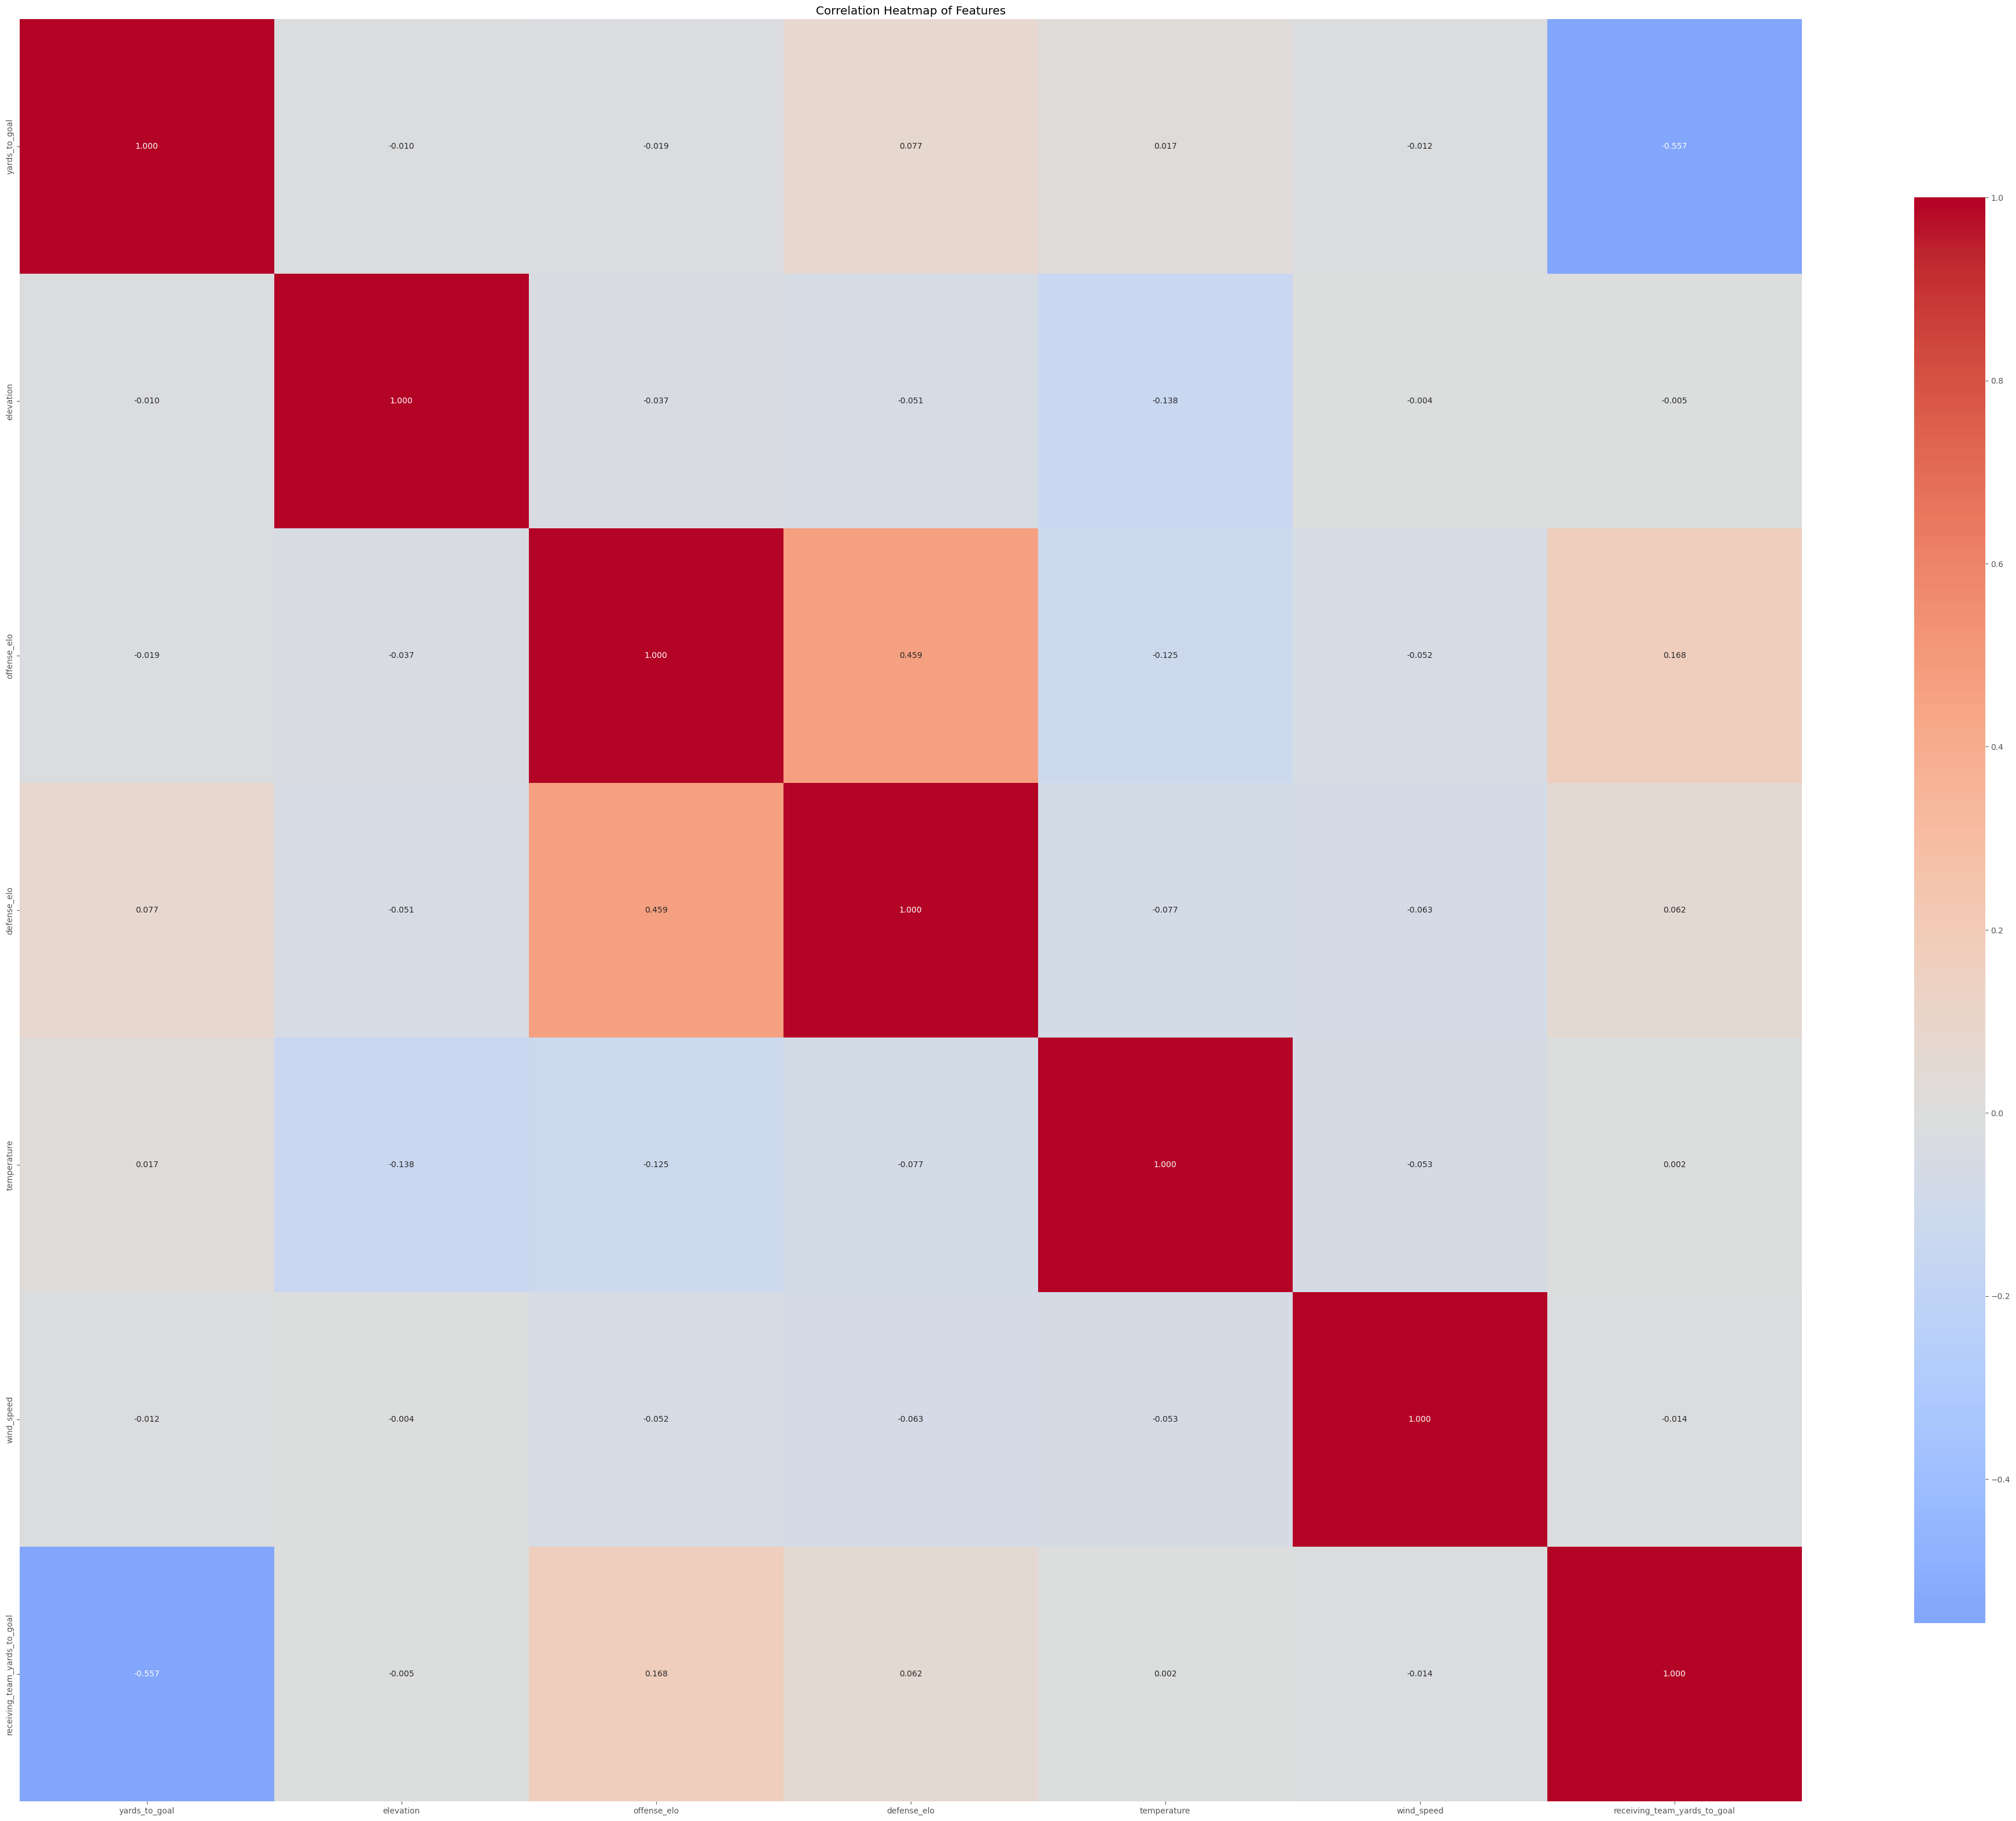

In [222]:
# correlation heatmap
plt.figure(figsize=(50, 40))
sns.heatmap(
    punt_return_results[feature_names + [target_variable]].corr(),
    annot=True, 
    fmt=".3f", 
    cmap='coolwarm', 
    center=0,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Correlation Heatmap of Features')
plt.show()

In [223]:
feature_names

['yards_to_goal',
 'elevation',
 'offense_elo',
 'defense_elo',
 'temperature',
 'wind_speed']

In [224]:
data = punt_return_results[feature_names + [target_variable]].dropna().copy()

SEED = 22
np.random.seed(SEED)

# Split into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=SEED)
train_x, valid_x, train_y, valid_y = train_test_split(
    train_data[feature_names], train_data[target_variable], 
    test_size=0.2, random_state=SEED
)
test_x, test_y = test_data[feature_names], test_data[target_variable]

# Create DMatrix objects for XGBoost
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

monotonic_constraints_map = {
    "yards_to_goal": -1,
    "offense_elo": 1,
    "defense_elo": -1,
    "wind_speed": -1,
    "elevation": 1,
}
monotonic_constraints = tuple([monotonic_constraints_map.get(feature, 0) for feature in feature_names])

# Train models for different quantiles
quantiles = [0.025, 0.5, 0.975]
# quantiles = [0.5]
quantile_models = {}

for quantile in quantiles:
    # Objective function for Optuna tuning
    def objective(trial, dtrain, dvalid):
        param = {
            "nthread": -1,
            "objective": "reg:quantileerror",
            "eval_metric": "mae",
            "booster": "gbtree",
            "quantile_alpha": quantile,
            "monotone_constraints": monotonic_constraints,
            "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
            "eta": trial.suggest_float("eta", 0.05, 0.3, step=0.01),
            "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
            "min_child_weight": trial.suggest_float("min_child_weight", 0.5, 10, step=0.5),
            "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
            "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "seed": SEED,
        }

        bst = xgb.train(
            param,
            dtrain,
            num_boost_round=500,
            evals=[(dvalid, "eval")],
            early_stopping_rounds=10,
            verbose_eval=False,
        )
        preds = bst.predict(dvalid)
        return mean_absolute_error(valid_y, preds)

    # Run Optuna study
    sampler = TPESampler(seed=SEED)
    study = optuna.create_study(
        study_name=f"punt_ytg_quantile_{quantile}",
        direction="minimize",
        load_if_exists=True,
        sampler=sampler
    )
    study.optimize(lambda trial: objective(trial, dtrain, dvalid), n_trials=50, show_progress_bar=True)

    # Train final model with best parameters
    best_params = {
        **study.best_trial.params,
        'monotone_constraints': monotonic_constraints,
        'nthread': -1,
        'objective': 'reg:quantileerror',
        'quantile_alpha': quantile,
        'eval_metric': 'mae',
        'booster': 'gbtree',
        'seed': SEED,
    }

    final_model = xgb.train(
        best_params,
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False
    )
    
    quantile_models[quantile] = final_model

# Make predictions for each quantile
for quantile in quantiles:
    punt_return_results[f'predicted_yards_gained_{int(quantile*100)}'] = quantile_models[quantile].predict(
        xgb.DMatrix(punt_return_results[feature_names])
    )


from sklearn.metrics import mean_absolute_error, r2_score
# Helper to compute metrics
def evaluate_set(name, X, y_true):
    dmatrix = xgb.DMatrix(X)
    y_pred = quantile_models[0.5].predict(dmatrix)

    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n=== {name.upper()} SET METRICS ===")
    print(f"Mean Absolute Error : {mae:.4f}")
    print(f"R^2 Score           : {r2:.4f}") 

# Evaluate the median quantile model (0.5)
evaluate_set("Train", train_x, train_y)
evaluate_set("Validation", valid_x, valid_y)
evaluate_set("Test", test_x, test_y)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


=== TRAIN SET METRICS ===
Mean Absolute Error : 10.1229
R^2 Score           : 0.3368

=== VALIDATION SET METRICS ===
Mean Absolute Error : 10.2676
R^2 Score           : 0.3232

=== TEST SET METRICS ===
Mean Absolute Error : 10.1999
R^2 Score           : 0.3269


In [225]:
# baseline model which predicts the mean yards gained
baseline_mean = train_y.median()
baseline_preds = np.full_like(valid_y, baseline_mean)  
baseline_mae = mean_absolute_error(valid_y, baseline_preds)
print(f"Baseline Mean MAE: {baseline_mae:.4f}")

Baseline Mean MAE: 14.5985


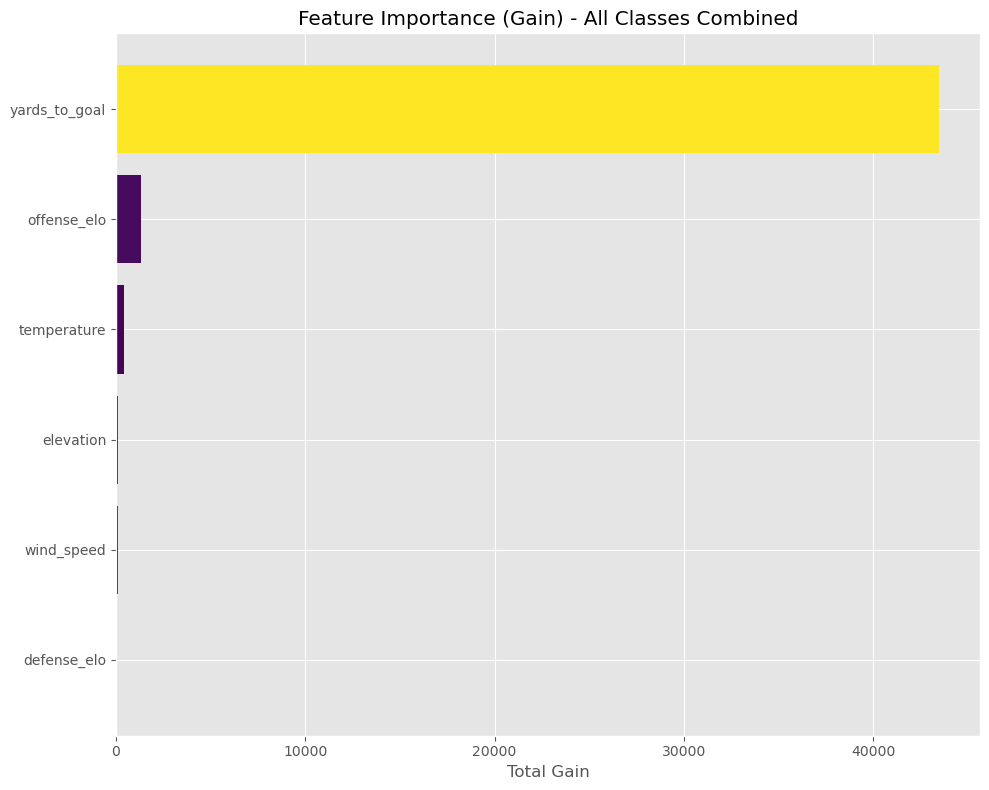

In [226]:
import matplotlib.cm as cm

trees_df = quantile_models[0.5].trees_to_dataframe()

# Aggregate gain across both classes
all_class_trees = trees_df[trees_df['Feature'] != 'Leaf']
total_gain = (
    all_class_trees
    .groupby('Feature')['Gain']
    .sum()
    .sort_values(ascending=False)
)
top_features = total_gain[:20]
norm = plt.Normalize(top_features.min(), top_features.max())
colors = cm.viridis(norm(top_features.values))

plt.figure(figsize=(10, 8))
plt.barh(top_features.index, top_features.values, color=colors)
plt.title("Feature Importance (Gain) - All Classes Combined")
plt.xlabel("Total Gain")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

100%|██████████| 5/5 [00:00<00:00,  7.44it/s]
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_61249/2891584250.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values,


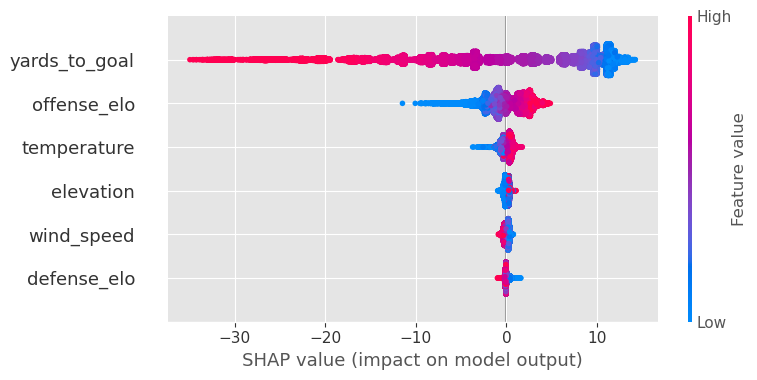

In [227]:
chunk_size = 10000
n_row = 100000

background = train_data[feature_names].iloc[:n_row]
explainer = shap.TreeExplainer(quantile_models[0.5])  # Use the median quantile model

num_rows = background.shape[0]

shap_values = []

for i in tqdm(range(0, num_rows, chunk_size)):
    chunk = background.iloc[i:i+chunk_size]
    shap_chunk = explainer(chunk)
    shap_values.append(shap_chunk.values)

shap_values = np.concatenate(shap_values, axis=0)

shap.summary_plot(shap_values, 
                 background,
                 plot_type="dot",  # "dot" (default), "bar", or "violin"
                 max_display=15,
                 show=True)

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_61249/444017674.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('yards_bin')
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_61249/444017674.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_punt_start_yards_to_goal['pred_yards_to_goal_median'] = df_punt_start_yards_to_goal['pred_yards_to_goal_median'].fillna(method='ffill')
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_61249/444017674.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_punt_start_yards_to_goal['receiving_team_start_yards_to_goal_median'] = df_punt_sta

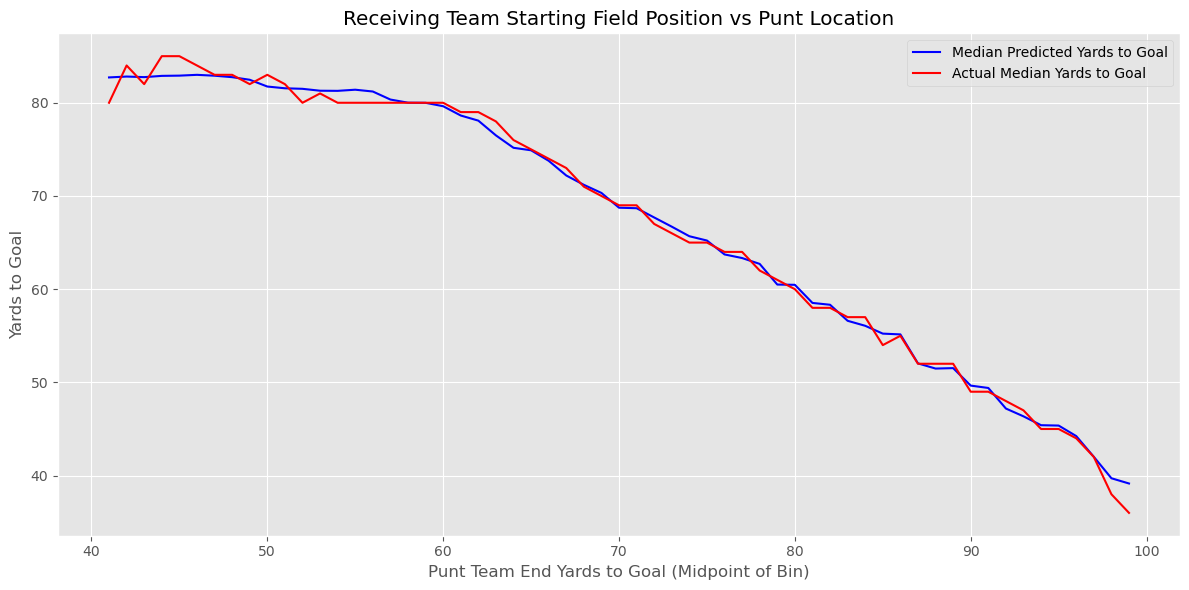

In [243]:
# Create the DataFrame with binned data
df_punt_start_yards_to_goal = (
    punt_return_results
    .assign(
        yards_bin=pd.cut(punt_return_results.yards_to_goal, np.linspace(40, 100, 60))
    )
    .groupby('yards_bin')
    .agg(
        pred_yards_to_goal_median=('predicted_yards_gained_50', 'median'),
        receiving_team_start_yards_to_goal_median=('receiving_team_yards_to_goal', 'median'),
        bin_midpoint=('yards_to_goal', lambda x: x.median())  # Calculate midpoint for plotting
    )
    .reset_index()
)

# Fill NA with previous value
df_punt_start_yards_to_goal['pred_yards_to_goal_median'] = df_punt_start_yards_to_goal['pred_yards_to_goal_median'].fillna(method='ffill')
df_punt_start_yards_to_goal['receiving_team_start_yards_to_goal_median'] = df_punt_start_yards_to_goal['receiving_team_start_yards_to_goal_median'].fillna(method='ffill')

# Plot with uncertainty shading
plt.figure(figsize=(12, 6))

# Prediction line
sns.lineplot(
    x='bin_midpoint',  # Use numeric midpoint instead of interval
    y='pred_yards_to_goal_median', 
    data=df_punt_start_yards_to_goal,
    color='blue',
    label='Median Predicted Yards to Goal'
)

# Actual median
sns.lineplot(
    x='bin_midpoint',  # Use numeric midpoint instead of interval
    y='receiving_team_start_yards_to_goal_median', 
    data=df_punt_start_yards_to_goal,
    color='red',
    label='Actual Median Yards to Goal'
)

plt.title("Receiving Team Starting Field Position vs Punt Location")
plt.xlabel("Punt Team End Yards to Goal (Midpoint of Bin)")
plt.ylabel("Yards to Goal")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [228]:
punt_return_results.query('endzone_punt==0').seconds_used.describe()

count    55078.000000
mean         8.612205
std          8.127920
min          0.000000
25%          0.000000
50%          7.000000
75%         12.000000
max         36.000000
Name: seconds_used, dtype: float64

In [229]:
model_dir = join('../models/raw', 'punt')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

for q_name, q in zip(["q025", "q50", "q975"], [0.025, 0.5, 0.975]):
    model_path = os.path.join(model_dir, f"punt_receiving_ytg_{q_name}_xgb.bin")
    quantile_models[q].save_model(model_path)
    print(f"Saved quantile {q_name} model to '{model_path}'")

Saved quantile q025 model to '../models/raw/punt/punt_receiving_ytg_q025_xgb.bin'
Saved quantile q50 model to '../models/raw/punt/punt_receiving_ytg_q50_xgb.bin'
Saved quantile q975 model to '../models/raw/punt/punt_receiving_ytg_q975_xgb.bin'


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_61249/3773516706.py:7: UserWarning: [18:05:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  quantile_models[q].save_model(model_path)


# Model 3: Punt blocked Recovery Yardline Model

In [230]:
punt_attempts.query('punt_blocked==1').shape

(1027, 32)

In [269]:
punt_attempts.query('punt_blocked==1').punt_outcome.value_counts()

punt_outcome
blocked              844
blocked touchdown    127
blocked safety        56
Name: count, dtype: int64

In [270]:
n_punt_block_td = punt_attempts.query('punt_outcome == "blocked touchdown"').shape[0]
n_punt_block_safety = punt_attempts.query('punt_outcome == "blocked safety"').shape[0]
n_punt_block_td_or_saftey = n_punt_block_td + n_punt_block_safety
print(f"Precentage of blocked punt endzone plays that were safety: {n_punt_block_safety / n_punt_block_td_or_saftey:.2%} ({n_punt_block_safety} of {n_punt_block_td_or_saftey})")
print(f"Precentage of blocked punt endzone plays that were touchdown: {n_punt_block_td / n_punt_block_td_or_saftey:.2%} ({n_punt_block_td} of {n_punt_block_td_or_saftey})")

Precentage of blocked punt endzone plays that were safety: 30.60% (56 of 183)
Precentage of blocked punt endzone plays that were touchdown: 69.40% (127 of 183)


In [231]:
# First assign time-based features
plays_with_next = (
    plays.rename(columns={
        'id': 'play_id',
    })
    .assign(
        pct_game_played = (
            (((plays['period'] - 1) * 15 * 60)
            + ((15 * 60) - (plays['clock_minutes'] * 60 + plays['clock_seconds']))) 
            / (4 * 15 * 60)
        ),
        seconds_remaining = (
            (4 * 15 * 60)
            - ((plays['period'] - 1) * 15 * 60)
            - (15 * 60 - (plays['clock_minutes'] * 60 + plays['clock_seconds']))
        )
    )
    .dropna(subset=['game_id','offense', 'yards_to_goal'])
    .sort_values(['game_id','pct_game_played'], ascending=[True, True])
)

# Then apply shifts within each game using a lambda
plays_with_next = (
    plays_with_next
    .assign(
        next_play_number = plays_with_next['play_number'].shift(-1),
        next_drive_number = plays_with_next['drive_number'].shift(-1),
        next_offense = plays_with_next['offense'].shift(-1),
        next_game_id = plays_with_next['game_id'].shift(-1),
        next_yards_to_goal = plays_with_next['yards_to_goal'].shift(-1),
        next_pct_game_played = plays_with_next['pct_game_played'].shift(-1),
        next_seconds_remaining = plays_with_next['seconds_remaining'].shift(-1),
    )
)


blocked_punt_results = pd.merge(
    punt_attempts.query('punt_blocked == 1'),
    plays_with_next[['game_id', 'play_id', 'next_play_number', 'next_drive_number', 
                    'next_offense', 'next_game_id', 'next_yards_to_goal', 
                    'next_pct_game_played', 'next_seconds_remaining']],
    on=['game_id', 'play_id'],
    how='left'
)

blocked_punt_results = blocked_punt_results[
    (
        (blocked_punt_results['next_offense'] != blocked_punt_results['offense']) &  # Possession changes
        (blocked_punt_results['next_game_id'] == blocked_punt_results['game_id']) &  # Same game
        (blocked_punt_results['next_pct_game_played'] >= blocked_punt_results['pct_game_played']) &  # Time moves forward
        (blocked_punt_results['next_pct_game_played'] <= (blocked_punt_results['pct_game_played'] + 0.01))  # Within reasonable time window
    ) |
    (
        blocked_punt_results['punt_outcome'].isin(['blocked touchdown', 'blocked safety']) # Special cases for blocked punt touchdowns or safeties
    )
]

blocked_punt_results['new_team_yards_to_goal'] = np.where(
    blocked_punt_results['punt_outcome'].isin(['blocked touchdown', 'blocked safety']),
    0,  # Touchdown results in 0 yards to goal
    blocked_punt_results['next_yards_to_goal']
)

blocked_punt_results = (
    blocked_punt_results
    .assign(
        new_team_yards_to_goal = np.where(
            blocked_punt_results.new_team_yards_to_goal < 0,
            0,
            np.where(
                blocked_punt_results.new_team_yards_to_goal > 100,
                99,
                blocked_punt_results.new_team_yards_to_goal
            )
        ),
        yards_gained =(100 - blocked_punt_results['yards_to_goal']) - blocked_punt_results['new_team_yards_to_goal'],
        seconds_used = blocked_punt_results['seconds_remaining'] - blocked_punt_results['next_seconds_remaining'],
        blocked_punt_td = np.where(
            blocked_punt_results['punt_outcome'].isin(['blocked touchdown', 'blocked safety']),
            1,
            0
        ),
    )
)

print(f"Found {len(blocked_punt_results)} blocked punts with valid next play data")

Found 628 blocked punts with valid next play data


In [232]:
blocked_punt_results.yards_gained.describe()

count    628.000000
mean       2.581210
std       24.948843
min      -68.000000
25%      -14.250000
50%        9.000000
75%       20.000000
max       56.000000
Name: yards_gained, dtype: float64

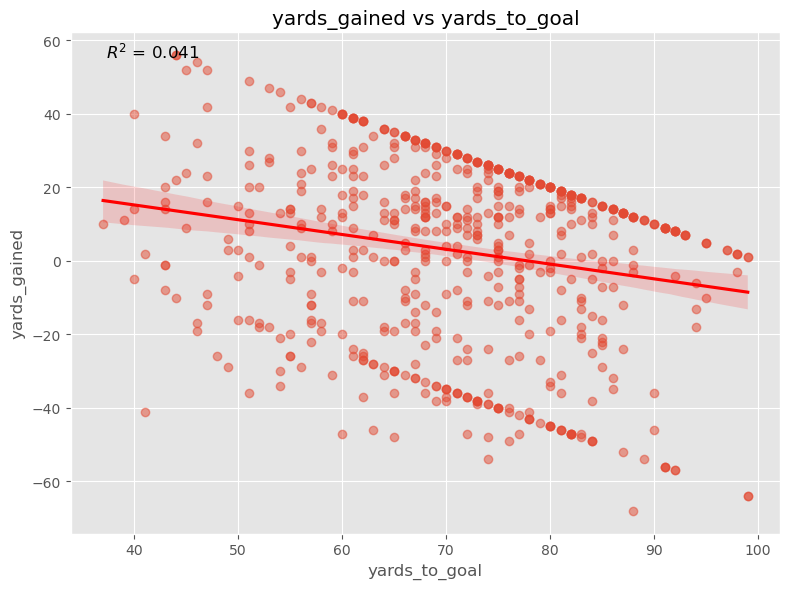

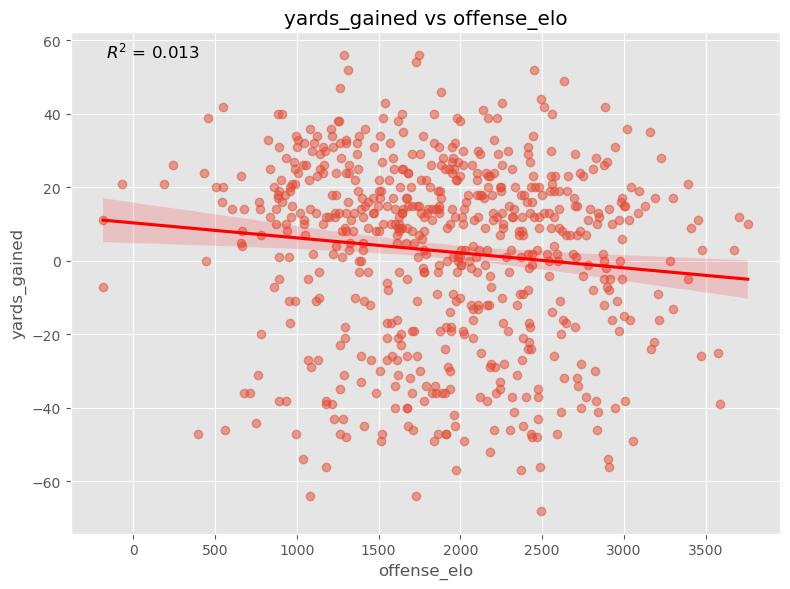

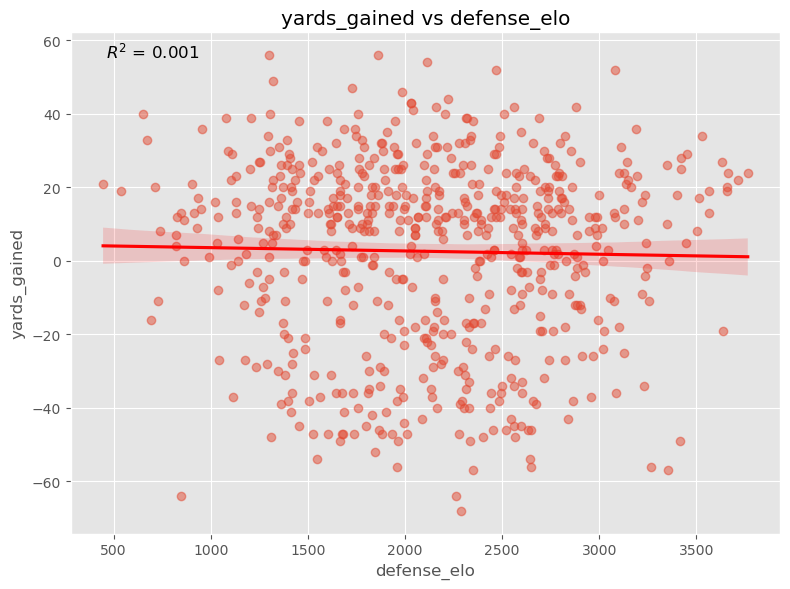

In [233]:
features = [
    'yards_to_goal', 'offense_elo', 'defense_elo'
]
target = 'yards_gained'

# plot each feature and the best fit line along with r^2 value
for feature in features:
    plt.figure(figsize=(8, 6))
    sns.regplot(
        x=feature, 
        y=target,
        data=blocked_punt_results, 
        scatter_kws={'alpha': 0.5}, 
        line_kws={'color': 'red'}
    )
    plt.title(f'{target} vs {feature}')
    plt.xlabel(feature)
    plt.ylabel(target)
    
    # Calculate and display r^2 value
    slope, intercept, r_value, p_value, std_err = linregress(
        blocked_punt_results[feature], 
        blocked_punt_results[target]
    )
    r_squared = r_value ** 2
    plt.text(0.05, 0.95, f'$R^2$ = {r_squared:.3f}', transform=plt.gca().transAxes, fontsize=12)
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

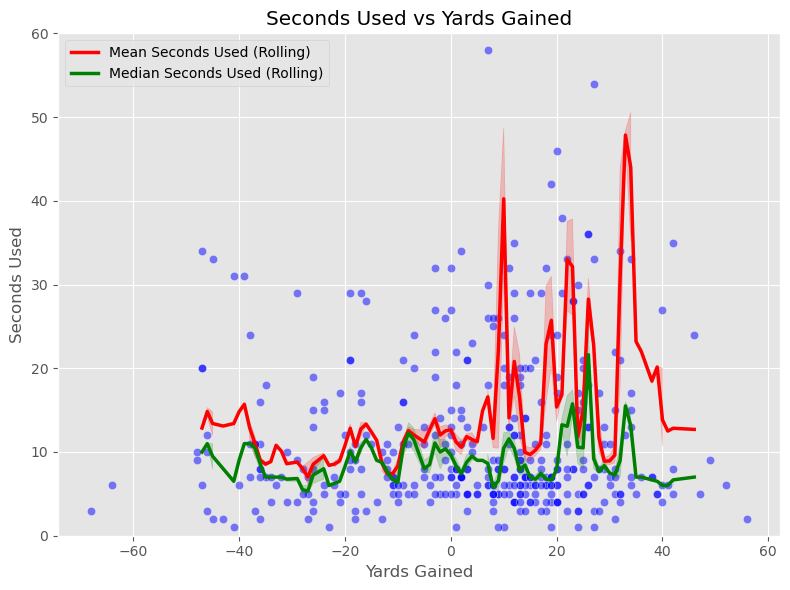

In [234]:
plt.figure(figsize=(8, 6))
qry = blocked_punt_results.query('seconds_used > 0')
# Scatter plot with flipped axes
sns.scatterplot(
    y='seconds_used',  # Now on y-axis
    x='yards_gained',  # Now on x-axis
    data=qry,
    alpha=0.5,
    color='blue'
)

# Calculate rolling mean and median with window of 3
rolling_stats = (
    qry
    .sort_values('yards_gained')
    .assign(
        rolling_mean=lambda df: df['seconds_used'].rolling(window=10, center=True).mean(),
        rolling_median=lambda df: df['seconds_used'].rolling(window=10, center=True).median()
    )
    .dropna()
)

# Plot rolling mean
sns.lineplot(
    x='yards_gained',
    y='rolling_mean',
    data=rolling_stats,
    color='red',
    linewidth=2.5,
    label='Mean Seconds Used (Rolling)'
)

# Plot rolling median
sns.lineplot(
    x='yards_gained',
    y='rolling_median',
    data=rolling_stats,
    color='green',
    linewidth=2.5,
    label='Median Seconds Used (Rolling)'
)

plt.title('Seconds Used vs Yards Gained')
plt.ylabel('Seconds Used')  # Now on y-axis
plt.xlabel('Yards Gained')  # Now on x-axis
plt.ylim(0, 60)  # Adjusted for seconds
# plt.xlim(-10, 100)  # Adjusted for yards
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [235]:
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split
import numpy as np

# Features and target
feature_names = ['yards_to_goal', 'offense_elo', 'defense_elo']
target_variable = 'yards_gained'

data = blocked_punt_results[feature_names + [target_variable]].dropna().copy()

SEED = 22
np.random.seed(SEED)

# Split into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=SEED)
train_x, valid_x, train_y, valid_y = train_test_split(
    train_data[feature_names], train_data[target_variable], 
    test_size=0.2, random_state=SEED
)
test_x, test_y = test_data[feature_names], test_data[target_variable]

# Create DMatrix objects for XGBoost
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

monotonic_constraints_map = {
    "yards_to_goal": -1,
    "offense_elo": -1,
    "defense_elo": 1,
}
monotonic_constraints = tuple([monotonic_constraints_map.get(feature, 0) for feature in feature_names])

# Train models for different quantiles
quantiles = [0.025, 0.5, 0.975]
quantile_models = {}

for quantile in quantiles:
    # Objective function for Optuna tuning
    def objective(trial, dtrain, dvalid):
        param = {
            "nthread": -1,
            "objective": "reg:quantileerror",
            "eval_metric": "mae",
            "booster": "gbtree",
            "quantile_alpha": quantile,
            "monotone_constraints": monotonic_constraints,
            "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
            "eta": trial.suggest_float("eta", 0.05, 0.3, step=0.01),
            "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
            "min_child_weight": trial.suggest_float("min_child_weight", 0.5, 10, step=0.5),
            "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
            "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "seed": SEED,
        }

        bst = xgb.train(
            param,
            dtrain,
            num_boost_round=500,
            evals=[(dvalid, "eval")],
            early_stopping_rounds=10,
            verbose_eval=False,
        )
        preds = bst.predict(dvalid)
        return mean_absolute_error(valid_y, preds)

    # Run Optuna study
    sampler = TPESampler(seed=SEED)
    study = optuna.create_study(
        study_name=f"yards_gained_quantile_{quantile}",
        direction="minimize",
        load_if_exists=True,
        sampler=sampler
    )
    study.optimize(lambda trial: objective(trial, dtrain, dvalid), n_trials=50, show_progress_bar=True)

    # Train final model with best parameters
    best_params = {
        **study.best_trial.params,
        'monotone_constraints': monotonic_constraints,
        'nthread': -1,
        'objective': 'reg:quantileerror',
        'quantile_alpha': quantile,
        'eval_metric': 'mae',
        'booster': 'gbtree',
        'seed': SEED,
    }

    final_model = xgb.train(
        best_params,
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False
    )
    
    quantile_models[quantile] = final_model

# Make predictions for each quantile
for quantile in quantiles:
    blocked_punt_results[f'predicted_yards_gained_{int(quantile*100)}'] = quantile_models[quantile].predict(
        xgb.DMatrix(blocked_punt_results[feature_names])
    )


from sklearn.metrics import mean_absolute_error, r2_score
# Helper to compute metrics
def evaluate_set(name, X, y_true):
    dmatrix = xgb.DMatrix(X)
    y_pred = quantile_models[0.5].predict(dmatrix)

    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n=== {name.upper()} SET METRICS ===")
    print(f"Mean Absolute Error : {mae:.4f}")
    print(f"R^2 Score           : {r2:.4f}") 

# Evaluate the median quantile model (0.5)
evaluate_set("Train", train_x, train_y)
evaluate_set("Validation", valid_x, valid_y)
evaluate_set("Test", test_x, test_y)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


=== TRAIN SET METRICS ===
Mean Absolute Error : 18.7384
R^2 Score           : 0.0088

=== VALIDATION SET METRICS ===
Mean Absolute Error : 19.7319
R^2 Score           : -0.0223

=== TEST SET METRICS ===
Mean Absolute Error : 19.3004
R^2 Score           : -0.0471


In [236]:
# baseline model which predicts the mean yards gained
baseline_mean = train_y.median()
baseline_preds = np.full_like(valid_y, baseline_mean)  
baseline_mae = mean_absolute_error(valid_y, baseline_preds)
print(f"Baseline Mean MAE: {baseline_mae:.4f}")

Baseline Mean MAE: 20.3861


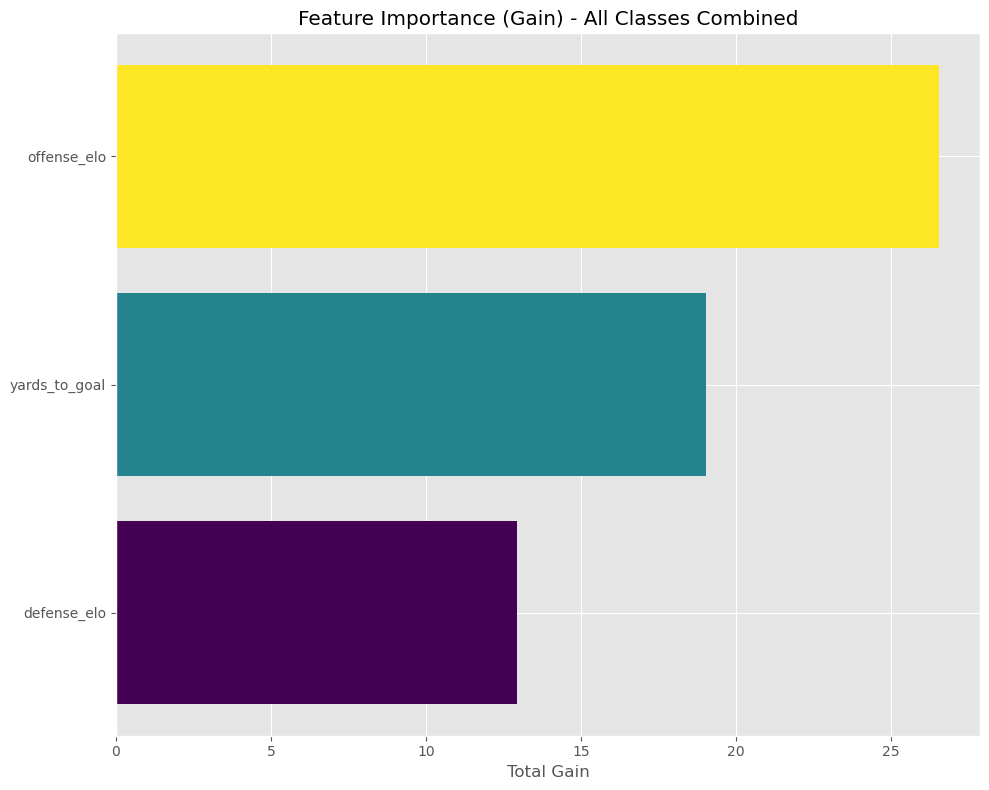

In [237]:
import matplotlib.cm as cm

trees_df = quantile_models[0.5].trees_to_dataframe()

# Aggregate gain across both classes
all_class_trees = trees_df[trees_df['Feature'] != 'Leaf']
total_gain = (
    all_class_trees
    .groupby('Feature')['Gain']
    .sum()
    .sort_values(ascending=False)
)
top_features = total_gain[:20]
norm = plt.Normalize(top_features.min(), top_features.max())
colors = cm.viridis(norm(top_features.values))

plt.figure(figsize=(10, 8))
plt.barh(top_features.index, top_features.values, color=colors)
plt.title("Feature Importance (Gain) - All Classes Combined")
plt.xlabel("Total Gain")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

100%|██████████| 1/1 [00:00<00:00, 431.20it/s]
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_61249/2891584250.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values,


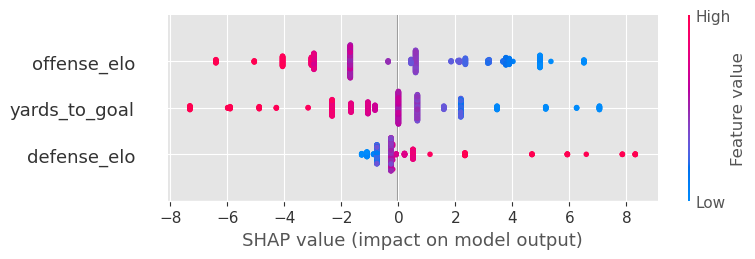

In [238]:
chunk_size = 10000
n_row = 100000

background = train_data[feature_names].iloc[:n_row]
explainer = shap.TreeExplainer(quantile_models[0.5])  # Use the median quantile model

num_rows = background.shape[0]

shap_values = []

for i in tqdm(range(0, num_rows, chunk_size)):
    chunk = background.iloc[i:i+chunk_size]
    shap_chunk = explainer(chunk)
    shap_values.append(shap_chunk.values)

shap_values = np.concatenate(shap_values, axis=0)

shap.summary_plot(shap_values, 
                 background,
                 plot_type="dot",  # "dot" (default), "bar", or "violin"
                 max_display=15,
                 show=True)

In [239]:
blocked_punt_results.query('blocked_punt_td==0').seconds_used.describe()

count    445.000000
mean       7.557303
std        8.708982
min        0.000000
25%        0.000000
50%        5.000000
75%       11.000000
max       36.000000
Name: seconds_used, dtype: float64

In [240]:
model_dir = join('../models/raw', 'punt')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

for q_name, q in zip(["q025", "q50", "q975"], [0.025, 0.5, 0.975]):
    model_path = os.path.join(model_dir, f"yards_gained_after_block_{q_name}_xgb.bin")
    quantile_models[q].save_model(model_path)
    print(f"Saved quantile {q_name} model to '{model_path}'")

Saved quantile q025 model to '../models/raw/punt/yards_gained_after_block_q025_xgb.bin'
Saved quantile q50 model to '../models/raw/punt/yards_gained_after_block_q50_xgb.bin'
Saved quantile q975 model to '../models/raw/punt/yards_gained_after_block_q975_xgb.bin'


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_61249/2140020700.py:7: UserWarning: [18:05:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  quantile_models[q].save_model(model_path)
